# Training with maximal update parameterization


In [1]:
XLA_PYTHON_CLIENT_MEM_FRACTION=.9

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
import jax.lax as lax

import wandb

from scipy.special import comb



In [2]:
import matplotlib

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams.update({'font.size': 12})
#matplotlib.rcdefaults()



In [2]:

def getfun(X0,X1,kmax):
    P=jnp.shape(X0)[0]
    Q=jnp.shape(X0)[1]
    
    idcs = jnp.tile(jnp.arange(P)[:, None], (1, Q))

    def compute_m_one(i):
        S = P * jnp.where(idcs == i, X0, 0)
        X0sub = jnp.where(idcs >= i, X0, 0)
        X1sub = jnp.where(idcs >= i, X1, 0)
        m_one = []
        for k in jnp.arange(kmax-1) + 1:
            S = ((k + 1) ** 2) / ((P - k) * (Q - k)) * cumsum2(cumsum2(S, axis=0) * X1sub, axis=1) * X0sub
            m_one.append(jnp.sum((jnp.sum(S, axis=0) / P) * X1[i, :]) / Q)
        return jnp.array(m_one)
    
    return compute_m_one


def cumsum2(x,axis=0):
    return jnp.cumsum(x,axis=axis)-x

def momest(X0,X1,kmax=5,reps=10,batch_size=100):
    P=jnp.shape(X0)[0]
    Q=jnp.shape(X0)[1]
    
    key = random.PRNGKey(0)
    Mvs2=[]
    for u in range(reps):
        key1,key2,key = random.split(key,3)
        X0_new=random.permutation(key2,random.permutation(key1, X0, axis=0),axis=1)
        X1_new=random.permutation(key2,random.permutation(key1, X1, axis=0),axis=1)
        compute_m_one = getfun(X0_new,X1_new,kmax)
        # Vectorize the computation across the first dimension
        compute_m_one_vmap = jax.vmap(compute_m_one, in_axes=(0,))
        #Ms = compute_m_one_vmap(jnp.arange(P))
        Ms = lax.map(compute_m_one, jnp.arange(P),batch_size=batch_size)
        Ms0 = jnp.sum(Ms, axis=0) / P
        Mvs2.append(np.squeeze(Ms0))    
    mv2=np.mean(np.array(Mvs2),axis=0)
    
    return mv2


2024-10-06 15:31:22.993720: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# of training images:60000
# of test images:10000


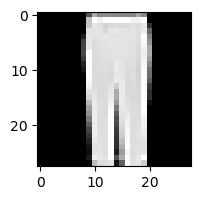

In [3]:
import os
import sys

file = open("../../../../zebra/meta.txt")
home = file.read().replace("\n", "/")
file.close()
    
p = os.path.abspath(home+'mypylib')
if p not in sys.path:
    sys.path.append(p)

import chunGP as gp

def loadData(dataName,N,P,seed=0):
    np.random.seed(seed)

    All=True
    if dataName=='MNIST':
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getMNIST(N_train=N,N_test=100,normalize=True,seed=seed,All=All)
    if dataName=='Fashion':
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getFashion(N_train=N,N_test=100,normalize=True,seed=seed,All=All,home=home)
    if dataName=='CIFAR':
        grayscale=False
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,All=All,home=home)
    if dataName=='CIFARG':
        grayscale=True
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,All=All,home=home)
        
    
    X=X/np.sqrt(np.sum(np.square(X),axis=1))[:,None]

    train_idx=np.random.choice(np.arange(N),P,replace=False)

    train_ID=np.ones(N)==0
    train_ID[train_idx]=True
    test_ID=np.invert(train_ID)

    x_train=X[train_ID,:]
    x_test=X[test_ID,:]

    y_train=Y[train_ID,:]
    y_test=Y[test_ID,:]
    
    return X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID


dataNames=['MNIST','Fashion','CIFAR','CIFARG']
dataName=dataNames[1]

P=10000
N=P+1000
seed=0
X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed)


In [4]:
def l1_norm(params):
    """Compute the L1 norm of the network parameters."""
    return sum(jnp.sum(jnp.square(w)) for w, _ in params)

# Define the activation function
def nonlin(x):
    return jnp.where(x > 0, x, 0)
    # beta = 4
    # return jnp.log1p(jnp.exp(beta * x)) / beta

# Initialize the neural network parameters
def init_network_params(layer_sizes, rng_key, var=1):
    params = []
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        key, rng_key = random.split(rng_key)
        weights = random.normal(key, (n_in, n_out)) * jnp.sqrt(var / n_in)
        biases = jnp.zeros(n_out)
        params.append((weights, biases))
    return params

# Initialize the neural network parameters with scaling
def init_network_params_SP(layer_sizes, rng_key, var=1):
    params = []
    n=layer_sizes[1]
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        key, rng_key = random.split(rng_key)
        #scaling = jnp.minimum(1.0, jnp.sqrt(n_out / n_in))
        #weights = random.normal(key, (n_in, n_out)) * jnp.sqrt(var / n_in) * scaling
        
        #scaling = jnp.sqrt(n_out / n_in)/(jnp.sqrt(n_out)+jnp.sqrt(n_in))
        weights = random.normal(key, (n_in, n_out)) * jnp.sqrt(var) /jnp.sqrt(n)

        biases = jnp.zeros(n_out)
        params.append((weights, biases))
    return params

# Forward pass for the neural network with L hidden layers
def forward_pass(params, x):
    activation = x
    # Forward pass through hidden layers
    acts = []
    for i, (w, b) in enumerate(params[:-1]):
        if i==0:
            n=jnp.shape(w)[1]
            scalef=jnp.sqrt(n)
        else:
            scalef=1
        activation = nonlin(scalef*jnp.dot(activation, w))
        acts.append(activation)
    w_out, b_out = params[-1]
    output = 1/jnp.sqrt(n)*jnp.dot(activation, w_out)# + b_out
    return output, acts

# Mean squared error loss function
def loss(params, x, y, l1_reg_coefficient=1e-5):
    prediction, _ = forward_pass(params, x)
    mse_loss = jnp.mean((prediction - y) ** 2)
    # l1_loss = l1_reg_coefficient * l1_norm(params)
    return mse_loss  # + l1_loss



In [12]:

# Hyperparameters
muP = True
epochs = 120 #60 #28
nps = 5
batch_size = 32  # Define the batch size for mini-batch training

width = 512 #16  # Adjust as needed

Qsub=16
Qsub=np.minimum(Qsub,width)

lro = 1e-2 #3e-3 #1e-4 #5e-6 # 1e-5 #1e-4
    
layer_sizes = [x_train.shape[1], width, y_train.shape[1]]  # Adjust the network architecture as needed
num_hidden = len(layer_sizes) - 2

seed_list=np.arange(1,30)

rng_key2 = random.PRNGKey(0)
for seedi in seed_list:
    # Initialize parameters
    randkey = seedi + width*1000
    rng_key = random.PRNGKey(randkey)

    if muP:
        runtype = 'muP'
        params = init_network_params_SP(layer_sizes, rng_key, var=1)
    else:
        runtype = 'typical'
        params = init_network_params(layer_sizes, rng_key, var=1)


    wandb.finish()

    # Start a new wandb run to track this script
    wandb.init(
        project="correct_MUP_{}hidden_both_faster_sub".format(num_hidden),

        # Track hyperparameters and run metadata
        config={
            "lro": lro,
            "epochs": epochs,
            "width": width,
            "moments": nps,
            "num_hidden": num_hidden,
            "rand_key": randkey,
            "batch_size": batch_size,
            "runtype":runtype,
            "Qsub":Qsub
        }
    )
        
    # Define scaling factors for per-parameter gradient scaling
    scales = []
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i + 1]
        if muP:
            #scale_w = n_out / n_in
            #scale_b = n_out
            if i==0:
                scale_w = 1/jnp.sqrt(n_out)
                scale_b = 1/jnp.sqrt(n_out)
            elif i==len(layer_sizes) - 2 :
                scale_w = 1/jnp.sqrt(n_in)
                scale_b = 1/jnp.sqrt(n_in)
            else:
                scale_w = 1/n_in
                scale_b = 1/n_in
        else:
            scale_w = 1.0
            scale_b = 1.0
        scales.append((scale_w, scale_b))

    def per_param_scale(scales):
        def init_fn(params):
            return optax.EmptyState()

        def update_fn(updates, state, params=None):
            scaled_updates = jax.tree_util.tree_map(lambda g, s: g * s, updates, scales)
            return scaled_updates, state

        return optax.GradientTransformation(init_fn, update_fn)

    # Define the optimizer
    optimizer = optax.chain(
        optax.adam(lro),
        per_param_scale(scales)
        #optax.sgd(lro)
    )

    # Initialize optimizer state
    opt_state = optimizer.init(params)

    # The training loop
    its = []
    errs = []
    errts = []
    num_train_samples = x_train.shape[0]

    @jit
    def train_step(params, x, y, opt_state):
        grads = grad(loss)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state
    # The training loop

    # The training loop
    its = []
    errs = []
    errts = []
    num_train_samples = x_train.shape[0]
    

    
    tstep=0
    for epoch in range(epochs):

        if epoch % 1 == 0:
            train_loss = loss(params, x_train, y_train)
            test_loss = loss(params, x_test, y_test)
            print("\rEpoch {}, Loss: {:.4e}, Test Loss: {:.4e}".format(epoch, train_loss, test_loss), end='')
            its.append(epoch)
            errs.append(train_loss)
            errts.append(test_loss)

            # Log metrics to wandb
            wandb.log({"iter": epoch, "loss/train": train_loss, "loss/test": test_loss})

        if epoch % 2 == 0:
            _, acts = forward_pass(params, x_test)

            for layn, act in enumerate(acts):
                if layn<len(acts)-1:
                    continue
                # Normalize activations
                #act = act - jnp.mean(act)
                #act = act / jnp.sqrt(jnp.mean(jnp.square(act)))

                K = jnp.matmul(act, act.T) / (jnp.shape(act)[1])
                s, _ = jnp.linalg.eigh(K / (jnp.shape(act)[0]))

                key2, rng_key2 = random.split(rng_key2)
                subID=random.choice(key2, jnp.arange(width), shape=(Qsub,), replace=False)
                
                act_sub=act[:,subID]
                K = jnp.matmul(act_sub.T, act_sub) / (jnp.shape(act_sub)[0])
                ssub, _ = jnp.linalg.eigh(K / (jnp.shape(act_sub)[1]))
                
                m_naive = []
                m_naive_sub=[]
                for power in np.arange(nps) + 1:
                    m_naive.append(jnp.sum(jnp.power(s, power)))
                    m_naive_sub.append(jnp.sum(jnp.power(ssub, power)))

                wandb.log({"mom_iter": epoch})

                wandb.log({f"moments-{layn + 1}/{i + 1}-naive": val for i, val in enumerate(m_naive)})
                wandb.log({f"moments-{layn + 1}/ED": (m_naive[0] ** 2) / (m_naive[1])})
                wandb.log({f"sub_moments-{layn + 1}/{i + 1}-sub_naive": val for i, val in enumerate(m_naive_sub)})
                
                m_est = momest(act, act, kmax=nps, reps=1)
                wandb.log({f"moments-{layn + 1}/{i + 2}-est": val for i, val in enumerate(m_est)})
                wandb.log({f"moments-{layn + 1}/ED_est": (m_naive[0] ** 2) / (m_est[0])})
                
                m_est_sub = momest(act_sub, act_sub, kmax=nps, reps=1)
                wandb.log({f"sub_moments-{layn + 1}/{i + 2}-sub_est": val for i, val in enumerate(m_est_sub)})
                wandb.log({f"sub_moments-{layn + 1}/ED_sub_est": (m_naive_sub[0] ** 2) / (m_est_sub[0])})
                
                ###
                
                wandb.log({f"norm_moments-{layn + 1}/{i + 1}-naive": val/(m_naive[0] ** (i+1)) for i, val in enumerate(m_naive)})
                wandb.log({f"norm_sub_moments-{layn + 1}/{i + 1}-sub_naive": val/(m_naive_sub[0] ** (i+1)) for i, val in enumerate(m_naive_sub)})
                
                wandb.log({f"norm_moments-{layn + 1}/{i + 2}-est": val/(m_naive[0] ** (i+2)) for i, val in enumerate(m_est)})
                
                wandb.log({f"norm_sub_moments-{layn + 1}/{i + 2}-sub_est": val/(m_naive_sub[0] ** (i+2)) for i, val in enumerate(m_est_sub)})
                

        # Shuffle the data at the start of each epoch
        key = random.PRNGKey(epoch+seedi)
        perm = random.permutation(key, num_train_samples)
        x_train_shuffled = x_train[perm]
        y_train_shuffled = y_train[perm]

        # Process mini-batches
        for i in range(0, num_train_samples, batch_size):

            x_batch = x_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            params, opt_state = train_step(params, x_batch, y_batch, opt_state)

            tstep+=1
            
    # [optional] finish the wandb run, necessary in notebooks
    wandb.finish()

    print('')



wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_150243-zoh913z2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cool-morning-146
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/zoh913z2


Epoch 119, Loss: 3.1730e-03, Test Loss: 2.9042e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
wandb:                moments-1/2-est ▁█▆▅▅▄▅▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▅▅▆▅▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▃▄▃▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▃▄▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇
wandb:                moments-1/4-est ▁█▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_150409-5ulsix09
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run peachy-sunset-147
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/5ulsix09


Epoch 119, Loss: 2.4546e-03, Test Loss: 2.8194e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_150537-bxllxw5t
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dulcet-disco-148
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/bxllxw5t


Epoch 119, Loss: 2.5777e-03, Test Loss: 2.8216e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████
wandb:                moments-1/2-est ▁█▆▅▅▄▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▄▃▃▄▃▄▄▄▃▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▃▄▄▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▂▃▃▂▂▂▂▂▃▃▃▂▂▃▃▃▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_150706-kb9n6dik
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run youthful-dragon-149
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/kb9n6dik


Epoch 119, Loss: 2.6060e-03, Test Loss: 2.8169e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/2-naive ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▂▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃
wandb:                moments-1/4-est ▁█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_150830-wtl0zl5l
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lyric-puddle-150
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/wtl0zl5l


Epoch 119, Loss: 2.5874e-03, Test Loss: 2.8358e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▇▇▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▄▄▅▄▄
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▅
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▂▂▃▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▃▄▄▄▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_150955-dshvf7mp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run soft-water-151
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/dshvf7mp


Epoch 119, Loss: 2.7100e-03, Test Loss: 2.7630e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▇
wandb:              moments-1/2-naive ▁▇▅▅▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█▇▇███
wandb:                moments-1/3-est ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅
wandb:              moments-1/3-naive ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
wandb:                moments-1/4-est ▁█▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▂▂▂▃▂▃▃▃▃▃▃▃▃▄▃▄▄▄▄▅▅▆▅▆▆▇▇▇▇██
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_151119-jczip4po
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run absurd-shape-152
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/jczip4po


Epoch 119, Loss: 3.0752e-03, Test Loss: 2.9379e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▆▅▅▄▅▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▄▅▅▅▅▅▅▆▆▆▆▆▅▆▆▆▆▇▆▆▆▆▇▆▇▇▆▇▇
wandb:                moments-1/3-est ▁█▅▄▄▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▃▄▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▆▅▅▅▅▆▅▆▆▅▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▃▂▂▂▂▂▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▂▃▃▃▃▃▄▄▄▄▄▄▃▄▄▅▄▅▄▅▅▅▅▅▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_151244-kf702m0i
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wild-butterfly-153
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/kf702m0i


Epoch 119, Loss: 2.6278e-03, Test Loss: 2.7891e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▅▅▅▅▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▅▅▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▄▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▅▆▆▆▆▆▆▆▆▇▆▇▆▇▇▇▇▆
wandb:                moments-1/4-est ▁█▃▃▃▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▃▃▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▅▅▆▅▆▆▆▆▆▆▇▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_151505-wz7vbypx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fine-sponge-154
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/wz7vbypx


Epoch 119, Loss: 2.5069e-03, Test Loss: 2.8045e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▅▅▅▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▅▆
wandb:              moments-1/2-naive ▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▄▄▄▄▃▃▃▄▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▂▃▂▃▂▃▂▂▃▂▃▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_151630-udpo5ej4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fresh-mountain-155
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/udpo5ej4


Epoch 119, Loss: 2.5688e-03, Test Loss: 2.8326e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
wandb:                moments-1/2-est ▁█▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▄▄▃▄▄▃▃▄▃▃▃▄▄▄▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▃▂▃▃▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▃▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_151754-d71oj9gl
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run zesty-water-156
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/d71oj9gl


Epoch 119, Loss: 2.4571e-03, Test Loss: 2.7147e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▄▅▄▄▄▄▄▃▃▄▄▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/2-naive ▁█▄▅▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/3-est ▁█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃
wandb:              moments-1/3-naive ▁█▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▂▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_151919-ut08ku4y
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run skilled-moon-157
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/ut08ku4y


Epoch 119, Loss: 2.7434e-03, Test Loss: 2.8150e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▄▄▄▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄
wandb:              moments-1/4-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▄▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_152043-jdzr07bf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fast-star-158
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/jdzr07bf


Epoch 119, Loss: 2.6111e-03, Test Loss: 2.7948e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
wandb:                moments-1/2-est ▁█▆▅▅▅▄▄▄▄▄▄▅▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▃▄▄▄▄▄▃▃▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▃▂▃▂▂▂▂▂▂▃▂▂▃▃▃▂▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▂▂▂▂▂▃▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_152207-ov4y1h5t
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run deft-morning-159
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/ov4y1h5t


Epoch 119, Loss: 2.7810e-03, Test Loss: 2.8526e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇███████████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▄▃▄▄▃▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_152336-fj8xtcz9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run generous-elevator-160
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/fj8xtcz9


Epoch 119, Loss: 2.5442e-03, Test Loss: 2.8582e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅
wandb:                moments-1/4-est ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▃▃▂
wandb:              moments-1/4-naive ▁█▄▃▃▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▃▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_152501-gojmvblt
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run warm-wind-161
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/gojmvblt


Epoch 119, Loss: 2.8146e-03, Test Loss: 2.7607e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅
wandb:              moments-1/2-naive ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▃▃▃▃▂▂▃▂▂▂▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▂▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_152625-f6d0qb93
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run colorful-flower-162
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/f6d0qb93


Epoch 119, Loss: 2.6452e-03, Test Loss: 2.7822e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▇▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▅▄▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▂▂▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_152749-vvbto4ye
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run winter-brook-163
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/vvbto4ye


Epoch 119, Loss: 2.5723e-03, Test Loss: 2.7589e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▅
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▃▄▃▄▄▃▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▂▂▂▂▂▂▃▂▂▃▂▃▂
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▃▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▆▆▆▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_152914-tspght0p
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run exalted-silence-164
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/tspght0p


Epoch 119, Loss: 2.3274e-03, Test Loss: 2.8887e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▇▇▇▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄
wandb:                moments-1/4-est ▁█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_153038-v1ledm1z
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run skilled-snow-165
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/v1ledm1z


Epoch 119, Loss: 2.8455e-03, Test Loss: 2.7699e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▆▅▅▅▄▄▅▄▅▅▅▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▄▄▃▃▃▃▃▃▃▃▃▄▃▄▃▃▄▄▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▃▃▄▃▃▃▃▄▄▄▄▄▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▃▂▂▂▂▂▂▃▃▃▂▂▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_153207-by138vzc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run effortless-mountain-166
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/by138vzc


Epoch 119, Loss: 2.4160e-03, Test Loss: 2.7711e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▅▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇
wandb:                moments-1/3-est ▁█▅▄▄▄▃▄▃▄▃▃▄▄▄▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_153331-7i95grlk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run woven-cherry-167
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/7i95grlk


Epoch 119, Loss: 2.8752e-03, Test Loss: 2.8947e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇
wandb:              moments-1/2-naive ▁▇▅▅▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▄▃▄▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁▇▄▄▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇█▇██
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁▇▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_153456-ad659ia9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run eager-sun-168
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/ad659ia9


Epoch 119, Loss: 2.3790e-03, Test Loss: 2.7617e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▅▅▄▄▅▅▅▅▅▅▅▅▅▅▆▅▆▅▆▅▅▆▅▆▆▆▆▆▆▅▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▃▃▃▄▃▄▄▄▄▄▄▃▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▄▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▅▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▅
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▃▂▂▂▂▃▂▃▃▃▃▃▃▂▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_153620-l4qd5ay9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run chocolate-puddle-169
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/l4qd5ay9


Epoch 119, Loss: 2.6185e-03, Test Loss: 2.7820e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_153805-2iuqm96i
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lucky-forest-170
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/2iuqm96i


Epoch 119, Loss: 2.4356e-03, Test Loss: 2.8258e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▅▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▃▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▄▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_153930-kd0jl76e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run absurd-sunset-171
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/kd0jl76e


Epoch 119, Loss: 2.5195e-03, Test Loss: 2.8260e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_154054-gsq5ien6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run magic-vortex-172
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/gsq5ien6


Epoch 119, Loss: 2.6230e-03, Test Loss: 2.8136e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▄▄▃▄▄▃▄▃▄▃▃▄▃▄▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▄▅▄▅▅▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_154223-uzd0gz30
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run upbeat-resonance-173
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/uzd0gz30


Epoch 119, Loss: 2.4090e-03, Test Loss: 2.9113e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▆▅▄▅▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▃▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▄▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▃▂▃▃▃▃▂▃▃▂
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241002_154347-uvp8yi7o
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run different-snow-174
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub/runs/uvp8yi7o


Epoch 119, Loss: 2.5324e-03, Test Loss: 2.7406e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁█▇▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄
wandb:              moments-1/2-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/3-est ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/3-naive ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃
wandb:                moments-1/4-est ▁█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▂▂▂▂▂▁▁▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:          

In [2]:
XLA_PYTHON_CLIENT_MEM_FRACTION=.1

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
import jax.lax as lax
import pandas as pd

import wandb

import matplotlib
matplotlib.rcParams.update({'font.size': 12})



# Initialize the wandb API
api = wandb.Api()

# Replace with your actual entity (username or team) and project name
entity = "neuralmachine"  # e.g., "john_doe" or "my_team"
project_base = "correct_MUP"

# If your project name includes dynamic parts like `num_hidden`, handle accordingly
# For example, if `num_hidden=1`, your project name might be "correct_MUP_1hidden_both_faster_sub"
num_hidden = 1  # Adjust this based on your setup
project = f"{project_base}_{num_hidden}hidden_both_faster_sub"

# Retrieve all runs in the project
runs = api.runs(f"{entity}/{project}")


In [34]:

# Initialize an empty list to collect data from all runs
all_runs_data = []

# Iterate through each run and retrieve its full history
for run in runs:
    print(f"Processing run: {run.id} | Name: {run.name}")

    # Retrieve run configuration
    config = run.config
    kmax=config.get("moments", "unknown")
    width = config.get("width", "unknown")  # Default to "unknown" if not found
    
    # Use scan_history to get the full history without downsampling
    run_history = run.scan_history()
    
    # Convert generator to list of dicts
    run_history = list(run_history)
    
    # Convert to pandas DataFrame
    run_df = pd.DataFrame(run_history)
    
    # Add run-specific information
    run_df['run_id'] = run.id
    run_df['run_name'] = run.name
    run_df['width'] = width
    
    # Append to the list
    all_runs_data.append(run_df)

Processing run: bqunxmkv | Name: swept-gorge-1
Processing run: 3tmoft3m | Name: fallen-wood-2
Processing run: svk7y88j | Name: sleek-sponge-3
Processing run: vs3xptqk | Name: radiant-snow-4
Processing run: aazcsg2u | Name: morning-donkey-5
Processing run: qpprmhpk | Name: smooth-wood-6
Processing run: 5go1umev | Name: twilight-river-7
Processing run: lrvwbhko | Name: jumping-star-8
Processing run: tgzuqvep | Name: pleasant-cosmos-9
Processing run: 713n0dnq | Name: radiant-elevator-10
Processing run: 0jsy2csb | Name: breezy-forest-11
Processing run: gnux9d1i | Name: wandering-leaf-12
Processing run: ervdhifw | Name: deft-night-13
Processing run: dcrzsk81 | Name: deft-bee-14
Processing run: yv2tq31c | Name: fresh-darkness-15
Processing run: mjcodw1y | Name: devout-tree-16
Processing run: kqtvi1gf | Name: dulcet-galaxy-17
Processing run: pbt81mia | Name: solar-fog-18
Processing run: r18c3vz3 | Name: exalted-eon-19
Processing run: xt4nqslr | Name: youthful-bush-20
Processing run: gru2jl72 

Processing run: v1ledm1z | Name: skilled-snow-165
Processing run: by138vzc | Name: effortless-mountain-166
Processing run: 7i95grlk | Name: woven-cherry-167
Processing run: ad659ia9 | Name: eager-sun-168
Processing run: l4qd5ay9 | Name: chocolate-puddle-169
Processing run: 2iuqm96i | Name: lucky-forest-170
Processing run: kd0jl76e | Name: absurd-sunset-171
Processing run: gsq5ien6 | Name: magic-vortex-172
Processing run: uzd0gz30 | Name: upbeat-resonance-173
Processing run: uvp8yi7o | Name: different-snow-174


In [101]:

# Concatenate all run data into a single DataFrame
df = pd.concat(all_runs_data, ignore_index=True)

# Optional: Save the DataFrame to a CSV file for future use
df.to_csv('wandb_exported_full_data.csv', index=False)
print("Data exported to 'wandb_exported_full_data.csv'.")

# Display basic information about the DataFrame
print("DataFrame Information:")
print(df.info())

# Display a preview of the DataFrame
print("\nDataFrame Preview:")
print(df.head())



In [3]:
csv_file_path='wandb_exported_full_data.csv'
df = pd.read_csv(csv_file_path)

In [7]:
kmax=5

trloss=[]
teloss=[]

#plt.figure(figsize=(12, 6))
widths=[]
# Iterate through each unique run and plot its training and test loss
m_n=[]
e_n=[]
m_s_n=[]
m_e=[]
e_e=[]
m_s_e=[]
e_s_e=[]
m_r_n=[]
m_r_s_n=[]
m_r_e=[]
m_r_s_e=[]
for run_id in df['run_id'].unique():
    run_data = df[df['run_id'] == run_id]
    
    nanfree=~np.isnan(run_data['iter'])
    it=np.array(run_data['iter'][nanfree])
    
    trloss.append(run_data['loss/train'][nanfree])
    teloss.append(run_data['loss/test'][nanfree])
    widths.append(np.array(run_data['width'])[0])
    

    
    itm=run_data['mom_iter']
    itm=np.array(itm)
    itm=itm[~np.isnan(itm)]

    
    layn=0
    
    mom_naive=[]
    ed_naive=[]
    momsub_naive=[]
    mom_est=[]
    ed_est=[]
    momsub_est=[]
    edsub_est=[]
    mom_norm_naive=[]
    momsub_norm_naive=[]
    mom_norm_est=[]
    momsub_norm_est=[]
    for i in range(kmax):
        d=run_data[f"moments-{layn + 1}/{i + 1}-naive"]
        mom_naive.append(d[~np.isnan(d)])
        d=run_data[f"sub_moments-{layn + 1}/{i + 1}-sub_naive"]
        momsub_naive.append(d[~np.isnan(d)]) 
        d=run_data[f"norm_moments-{layn + 1}/{i + 1}-naive"]
        mom_norm_naive.append(d[~np.isnan(d)])
        d=run_data[f"norm_sub_moments-{layn + 1}/{i + 1}-sub_naive"]
        momsub_norm_naive.append(d[~np.isnan(d)])
        
        if i<kmax-1:
            d=run_data[f"moments-{layn + 1}/{i + 2}-est"]
            mom_est.append(d[~np.isnan(d)])
            d=run_data[f"sub_moments-{layn + 1}/{i + 2}-sub_est"]
            momsub_est.append(d[~np.isnan(d)])
            d=run_data[f"norm_moments-{layn + 1}/{i + 2}-est"]
            mom_norm_est.append(d[~np.isnan(d)])
            d=run_data[f"norm_sub_moments-{layn + 1}/{i + 2}-sub_est"]
            momsub_norm_est.append(d[~np.isnan(d)])

        #ed_naive.append(run_data[f"moments-{layn + 1}/ED"][~np.isnan(itm)])
        #ed_est.append(run_data[f"moments-{layn + 1}/ED_est"][~np.isnan(itm)])
        #edsub_est.append(run_data[f"sub_moments-{layn + 1}/ED_sub_est"][~np.isnan(itm)])
        
    m_n.append(mom_naive)
    e_n.append(ed_naive)
    m_s_n.append(momsub_naive)
    m_e.append(mom_est)
    m_s_e.append(momsub_est)
    e_s_e.append(edsub_est)
    m_r_n.append(mom_norm_naive)
    m_r_s_n.append(momsub_norm_naive)
    m_r_e.append(mom_norm_est)
    m_r_s_e.append(momsub_norm_est)


trloss=np.array(trloss).T
teloss=np.array(teloss).T
widths=np.array(widths)

m_n=np.array(m_n)
m_e=np.array(m_e)
m_s_n=np.array(m_s_n)
m_s_e=np.array(m_s_e)
m_r_n=np.array(m_r_n)
m_r_e=np.array(m_r_e)
m_r_s_n=np.array(m_r_s_n)
m_r_s_e=np.array(m_r_s_e)

#e_n=np.array(e_n)
#e_e=np.array(e_e)
#e_s_e=np.array(e_s_e)

itm=itm[~np.isnan(itm)]

#plt.xlabel('Iteration')
#plt.ylabel('Loss')
#plt.title('Training and Test Loss over Iterations')
#plt.legend()
#plt.grid(True)
#plt.show()


In [9]:
def plot_ci(ax,xoi,qoi,c='k',zorder=10,alphaf=0.1,alphap=1,label=''):
    yval=np.nanmedian(qoi,axis=1)
    lower=np.nanquantile(qoi,axis=1,q=0.25)
    upper=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower, upper-yval]

    yval=np.nanmean(qoi,axis=1)
    ax.fill_between(xoi, lower, upper, color=c, alpha=alphaf,edgecolor='none')#, **fill_kwargs)
    ax.plot(xoi, yval, color=c,lw=1,alpha=alphap,label=label)

widthu=np.unique(widths)

color = plt.cm.rainbow(np.linspace(0, 1, len(widthu)))


fig,ax=plt.subplots(kmax-1,4,figsize=(10,6))
#fig,ax=plt.subplots(kmax-1,2,figsize=(5,6))
for mid in range(kmax-1):
    data0=m_n[:,mid+1,:]
    data1=m_e[:,mid,:]
    meand=[]
    meand=[]
    for i,width in enumerate(widthu):
        meand.append(np.mean(data0[widths==width,:],axis=0))
        meand.append(np.mean(data1[widths==width,:],axis=0))
        
        plot_ci(ax[mid][0],itm,data0[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        plot_ci(ax[mid][1],itm,data1[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        
    ymax = np.max(np.array(meand))
    ymin = np.min(np.array(meand))
        
    ax[mid][0].set_ylim([0,ymax])
    ax[mid][1].set_ylim([0,ymax])
    #ax[mid][2].set_ylim([ymin,ymax])
    #ax[mid][3].set_ylim([ymin,ymax])
    

    #ax[mid][0].set_yscale('log')
    #ax[mid][1].set_yscale('log')
    #ax[mid][2].set_yscale('log')
    #ax[mid][3].set_yscale('log')
        
#fig.tight_layout()
        
    
#fig,ax=plt.subplots(kmax-1,2,figsize=(5,6))
for mid in range(kmax-1):
    data0=m_r_n[:,mid+1,:]
    data1=m_r_e[:,mid,:]
    meand=[]
    meand=[]
    for i,width in enumerate(widthu):
        meand.append(np.mean(data0[widths==width,:],axis=0))
        meand.append(np.mean(data1[widths==width,:],axis=0))
        
        plot_ci(ax[mid][2],itm,data0[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        plot_ci(ax[mid][3],itm,data1[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        
    ymax = np.max(np.array(meand))
    ymin = np.min(np.array(meand))
        
    ax[mid][2].set_ylim([0,ymax])
    ax[mid][3].set_ylim([0,ymax])
    #ax[mid][2].set_ylim([ymin,ymax])
    #ax[mid][3].set_ylim([ymin,ymax])
    

    #ax[mid][0].set_yscale('log')
    #ax[mid][1].set_yscale('log')
    #ax[mid][2].set_yscale('log')
    #ax[mid][3].set_yscale('log')
    
ax[0][0].set_ylabel(r'$\hat{m}(2)$')
ax[1][0].set_ylabel(r'$\hat{m}(3)$')
ax[2][0].set_ylabel(r'$\hat{m}(4)$')
ax[3][0].set_ylabel(r'$\hat{m}(5)$')

ax[-1][0].set_xlabel('Epoch')
ax[-1][1].set_xlabel('Epoch')
ax[-1][2].set_xlabel('Epoch')
ax[-1][3].set_xlabel('Epoch')

ax[0][0].set_title('Naive')
ax[0][1].set_title('Ours')

ax[0][2].set_title(r'Naive (norm. $\Phi$)')
ax[0][3].set_title(r'Ours (norm. $\Phi$)')

#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title="Width")
fig.tight_layout()



In [15]:

widthu=np.unique(widths)

color = plt.cm.rainbow(np.linspace(0, 1, len(widthu)))


fig,ax=plt.subplots(2,4,figsize=(10,4))

start=1
#fig,ax=plt.subplots(kmax-1,2,figsize=(5,6))
for mid in range(kmax-1):
    data0=m_r_n[:,mid+1,start:]
    data1=m_r_e[:,mid,start:]
    meand=[]
    meand=[]
    for i,width in enumerate(widthu):
        meand.append(np.mean(data0[widths==width,:],axis=0))
        meand.append(np.mean(data1[widths==width,:],axis=0))
        
        plot_ci(ax[0][mid],itm[start:],data0[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        plot_ci(ax[1][mid],itm[start:],data1[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        
    ymax = np.max(np.array(meand))
    ymin = np.min(np.array(meand))
        
    ax[0][mid].set_ylim([0,ymax])
    ax[1][mid].set_ylim([0,ymax])
    #ax[mid][2].set_ylim([ymin,ymax])
    #ax[mid][3].set_ylim([ymin,ymax])
    

    #ax[mid][0].set_yscale('log')
    #ax[mid][1].set_yscale('log')
    #ax[mid][2].set_yscale('log')
    #ax[mid][3].set_yscale('log')
    
ax[0][0].set_title(r'$\hat{m}(2)$')
ax[0][1].set_title(r'$\hat{m}(3)$')
ax[0][2].set_title(r'$\hat{m}(4)$')
ax[0][3].set_title(r'$\hat{m}(5)$')

ax[-1][0].set_xlabel('Epoch')
ax[-1][1].set_xlabel('Epoch')
ax[-1][2].set_xlabel('Epoch')
ax[-1][3].set_xlabel('Epoch')

ax[0][0].set_ylabel('Naive')#,rotation=0)
ax[1][0].set_ylabel('Ours')

#ax[0][2].set_title(r'Naive (normalized $\Phi$)')
#ax[0][3].set_title(r'Ours (normalized $\Phi$)')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title="Width",fontsize=8)
fig.tight_layout()


fig.set_size_inches(w=6.75133, h=2.7)
plt.savefig('train_curves.pdf', bbox_inches='tight')
#plt.savefig('train_curves.pgf' , bbox_inches='tight')


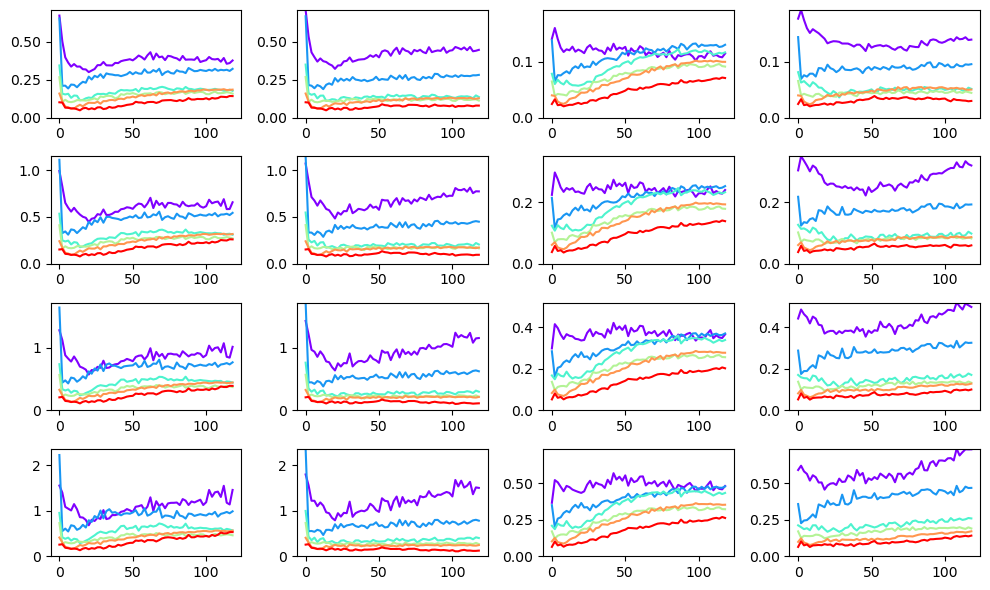

In [236]:

fig,ax=plt.subplots(kmax-1,4,figsize=(10,6))
#fig,ax=plt.subplots(kmax-1,2,figsize=(5,6))
for mid in range(kmax-1):
    data0=m_n[:,mid+1,:]
    data1=m_e[:,mid,:]
    ys=[]
    for i,width in enumerate(widthu):
        mean0v=np.mean(data0[widths==width,:],axis=0)
        mean1v=np.mean(data1[widths==width,:],axis=0)

        std0v=np.std(data0[widths==width,:],axis=0)
        std1v=np.std(data1[widths==width,:],axis=0)
        
        y0=std0v/mean0v
        y1=std1v/mean1v
        ys.append(y0)
        ys.append(y1)

        ax[mid][0].plot(itm,y0,c=color[i])
        ax[mid][1].plot(itm,y1,c=color[i])
        
    ax[mid][0].set_ylim([0,np.max(ys)])
    ax[mid][1].set_ylim([0,np.max(ys)])

#fig,ax=plt.subplots(kmax-1,2,figsize=(5,6))
for mid in range(kmax-1):
    data0=m_r_n[:,mid+1,:]
    data1=m_r_e[:,mid,:]
    ys=[]
    for i,width in enumerate(widthu):
        mean0v=np.mean(data0[widths==width,:],axis=0)
        mean1v=np.mean(data1[widths==width,:],axis=0)

        std0v=np.std(data0[widths==width,:],axis=0)
        std1v=np.std(data1[widths==width,:],axis=0)
        
        y0=std0v/mean0v
        y1=std1v/mean1v
        ys.append(y0)
        ys.append(y1)

        ax[mid][2].plot(itm,y0,c=color[i])
        ax[mid][3].plot(itm,y1,c=color[i])
        
    ax[mid][2].set_ylim([0,np.max(ys)])
    ax[mid][3].set_ylim([0,np.max(ys)])
        
fig.tight_layout()


# Initial condition only

In [5]:

# Hyperparameters
muP = True
epochs = 10
nps = 5
batch_size = 32  # Define the batch size for mini-batch training

width = 16 #16  # Adjust as needed

lro = 3e-3 #1e-4 #5e-6 # 1e-5 #1e-4
    
layer_sizes = [x_train.shape[1], width, y_train.shape[1]]  # Adjust the network architecture as needed
num_hidden = len(layer_sizes) - 2

seed_list=np.arange(1,30)+30

for seedi in seed_list:
    # Initialize parameters
    randkey = seedi + width*1000
    rng_key = random.PRNGKey(randkey)

    if muP:
        runtype = 'muP'
        params = init_network_params_SP(layer_sizes, rng_key, var=1)
    else:
        runtype = 'typical'
        params = init_network_params(layer_sizes, rng_key, var=1)


    wandb.finish()

    # Start a new wandb run to track this script
    wandb.init(
        project="{}hidden_init_only2".format(num_hidden),

        # Track hyperparameters and run metadata
        config={
            "lro": lro,
            "epochs": epochs,
            "width": width,
            "moments": nps,
            "num_hidden": num_hidden,
            "rand_key": randkey,
            "batch_size": batch_size,
            "runtype":runtype
        }
    )
        
    # Define scaling factors for per-parameter gradient scaling
    scales = []
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i + 1]
        if muP:
            #scale_w = n_out / n_in
            #scale_b = n_out
            if i==0:
                scale_w = 1/jnp.sqrt(n_out)
                scale_b = 1/jnp.sqrt(n_out)
            elif i==len(layer_sizes) - 2 :
                scale_w = 1/jnp.sqrt(n_in)
                scale_b = 1/jnp.sqrt(n_in)
            else:
                scale_w = 1/n_in
                scale_b = 1/n_in
        else:
            scale_w = 1.0
            scale_b = 1.0
        scales.append((scale_w, scale_b))

    def per_param_scale(scales):
        def init_fn(params):
            return optax.EmptyState()

        def update_fn(updates, state, params=None):
            scaled_updates = jax.tree_util.tree_map(lambda g, s: g * s, updates, scales)
            return scaled_updates, state

        return optax.GradientTransformation(init_fn, update_fn)

    # Define the optimizer
    optimizer = optax.chain(
        optax.adam(lro),
        per_param_scale(scales)
        #optax.sgd(lro)
    )

    # Initialize optimizer state
    opt_state = optimizer.init(params)

    # The training loop
    its = []
    errs = []
    errts = []
    num_train_samples = x_train.shape[0]

    @jit
    def train_step(params, x, y, opt_state):
        grads = grad(loss)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state
    # The training loop

    # The training loop
    its = []
    errs = []
    errts = []
    num_train_samples = x_train.shape[0]
    

    
    tstep=0
    for epoch in range(epochs):

        if epoch % 1 == 0:
            train_loss = loss(params, x_train, y_train)
            test_loss = loss(params, x_test, y_test)
            print("\rEpoch {}, Loss: {:.4e}, Test Loss: {:.4e}".format(epoch, train_loss, test_loss), end='')
            its.append(epoch)
            errs.append(train_loss)
            errts.append(test_loss)

            # Log metrics to wandb
            wandb.log({"iter": epoch, "loss/train": train_loss, "loss/test": test_loss})

        if epoch % 2 == 0:
            _, acts = forward_pass(params, x_test)

            for layn, act in enumerate(acts):
                if layn<len(acts)-1:
                    continue
                # Normalize activations
                #act = act - jnp.mean(act)
                #act = act / jnp.std(act)

                K = jnp.matmul(act, act.T) / (jnp.shape(act)[1])
                s, _ = jnp.linalg.eigh(K / (jnp.shape(act)[0]))

                m_naive = []
                for power in np.arange(nps) + 1:
                    m_naive.append(jnp.sum(jnp.power(s, power)))

                wandb.log({"mom_iter": epoch})

                wandb.log({f"moments-{layn + 1}/{i + 1}-naive": loss for i, loss in enumerate(m_naive)})
                wandb.log({f"moments-{layn + 1}/ED": (m_naive[0] ** 2) / (m_naive[1])})

                m_est = momest(act, act, kmax=nps, reps=1)
                wandb.log({f"moments-{layn + 1}/{i + 2}-est": loss for i, loss in enumerate(m_est)})
                wandb.log({f"moments-{layn + 1}/ED_est": (m_naive[0] ** 2) / (m_est[0])})

        key, rng_key = random.split(rng_key)

        if muP:
            runtype = 'muP'
            params = init_network_params_SP(layer_sizes, key, var=1)
        else:
            runtype = 'typical'
            params = init_network_params(layer_sizes, key, var=1)

        # Process mini-batches
        #for i in range(0, num_train_samples, batch_size):

#            x_batch = x_train_shuffled[i:i + batch_size]
#            y_batch = y_train_shuffled[i:i + batch_size]
#            params, opt_state = train_step(params, x_batch, y_batch, opt_state)

#            tstep+=1
            
    # [optional] finish the wandb run, necessary in notebooks
    wandb.finish()

    print('')



wandb: Currently logged in as: cc2465 (neuralmachine). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104706-xu1qguw8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run hearty-valley-28
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/xu1qguw8


Epoch 9, Loss: 1.1979e-01, Test Loss: 1.2145e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▁▃█▃▂▁▁▂▅▃
wandb:        loss/train ▁▃█▃▂▁▁▂▅▃
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▁█▂▅▃
wandb:   moments-1/2-est ▁█▁▄▂
wandb: moments-1/2-naive ▁█▁▄▂
wandb:   moments-1/3-est ▁█▁▃▁
wandb: moments-1/3-naive ▁█▁▃▁
wandb:   moments-1/4-est ▁█▁▃▁
wandb: moments-1/4-naive ▁█▁▃▁
wandb:   moments-1/5-est ▁█▁▂▁
wandb: moments-1/5-naive ▁█▁▂▁
wandb:      moments-1/ED █▁▄▁▂
wandb:  moments-1/ED_est █▁▄▁▂
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.12145
wandb:        loss/train 0.11979
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.43793
wandb:   moments-1/2-est 0.08248
wandb: moments-1/2-naive 0.10685
wandb:   moments-1/3-est 0.01782
wandb: moments-1/3-naive 0.034
wandb:   moments-1/4-est 0.00313
wandb: moments-1/4-naive 0.01099
wandb:   moments-1/5-est 0.0

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104717-2gd3afaj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run jumping-dew-29
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/2gd3afaj


Epoch 9, Loss: 1.2673e-01, Test Loss: 1.2637e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test █▁▁▄▄▄▁▅▃▂
wandb:        loss/train █▁▁▄▃▄▁▄▃▃
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▃▁█▃▁
wandb:   moments-1/2-est ▂▁█▂▁
wandb: moments-1/2-naive ▂▁█▂▁
wandb:   moments-1/3-est ▂▁█▂▁
wandb: moments-1/3-naive ▂▁█▁▁
wandb:   moments-1/4-est ▁▁█▁▁
wandb: moments-1/4-naive ▂▁█▁▁
wandb:   moments-1/5-est ▁▁█▁▁
wandb: moments-1/5-naive ▁▁█▁▁
wandb:      moments-1/ED ▂▇▁▇█
wandb:  moments-1/ED_est ▂█▁▄▅
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.12637
wandb:        loss/train 0.12673
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.40807
wandb:   moments-1/2-est 0.05132
wandb: moments-1/2-naive 0.07542
wandb:   moments-1/3-est 0.00825
wandb: moments-1/3-naive 0.01952
wandb:   moments-1/4-est 0.00112
wandb: moments-1/4-naive 0.00522
wandb:   moments-1/5-est 0

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104726-t5s18pcp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run still-river-30
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/t5s18pcp


Epoch 9, Loss: 1.1133e-01, Test Loss: 1.1156e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▃▄▄▅▁▃▅█▃▃
wandb:        loss/train ▃▄▄▅▁▃▄█▃▃
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▅▃▄█▁
wandb:   moments-1/2-est ▄▂▃█▁
wandb: moments-1/2-naive ▃▂▂█▁
wandb:   moments-1/3-est ▅▁▃█▁
wandb: moments-1/3-naive ▂▁▂█▁
wandb:   moments-1/4-est ▅▁▃█▁
wandb: moments-1/4-naive ▂▁▁█▁
wandb:   moments-1/5-est ▅▁▃█▁
wandb: moments-1/5-naive ▂▁▁█▁
wandb:      moments-1/ED ▃▇▆▁█
wandb:  moments-1/ED_est ▁█▃▁▇
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.11156
wandb:        loss/train 0.11133
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.15405
wandb:   moments-1/2-est 0.00396
wandb: moments-1/2-naive 0.00687
wandb:   moments-1/3-est 0.00018
wandb: moments-1/3-naive 0.00048
wandb:   moments-1/4-est 1e-05
wandb: moments-1/4-naive 4e-05
wandb:   moments-1/5-est 0.0
w

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104734-f0k6pbt4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run youthful-surf-31
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/f0k6pbt4


Epoch 9, Loss: 1.6234e-01, Test Loss: 1.6060e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▅▁▅▄▃▇▂▄▃█
wandb:        loss/train ▅▁▅▄▂▆▁▄▄█
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive █▅▇▃▁
wandb:   moments-1/2-est █▄▇▃▁
wandb: moments-1/2-naive █▅▅▂▁
wandb:   moments-1/3-est ▅▃█▄▁
wandb: moments-1/3-naive █▄▅▂▁
wandb:   moments-1/4-est ▃▂█▄▁
wandb: moments-1/4-naive █▃▄▂▁
wandb:   moments-1/5-est ▂▁█▄▁
wandb: moments-1/5-naive █▃▄▁▁
wandb:      moments-1/ED ▁▂▃▆█
wandb:  moments-1/ED_est ▂▆▁▂█
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.1606
wandb:        loss/train 0.16234
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.41601
wandb:   moments-1/2-est 0.05334
wandb: moments-1/2-naive 0.07674
wandb:   moments-1/3-est 0.00915
wandb: moments-1/3-naive 0.02002
wandb:   moments-1/4-est 0.00134
wandb: moments-1/4-naive 0.0054
wandb:   moments-1/5-est 0.0

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104742-b4uyg3lz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run azure-universe-32
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/b4uyg3lz


Epoch 9, Loss: 1.4534e-01, Test Loss: 1.4565e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▁▆▁█▃▁▁▄▁▅
wandb:        loss/train ▁▆▁█▃▁▁▄▁▅
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▁▁█▁▁
wandb:   moments-1/2-est ▁▁█▁▁
wandb: moments-1/2-naive ▁▁█▁▁
wandb:   moments-1/3-est ▁▁█▁▁
wandb: moments-1/3-naive ▁▁█▁▁
wandb:   moments-1/4-est ▁▁█▁▁
wandb: moments-1/4-naive ▁▁█▁▁
wandb:   moments-1/5-est ▁▁█▁▁
wandb: moments-1/5-naive ▁▁█▁▁
wandb:      moments-1/ED █▁▁▄▇
wandb:  moments-1/ED_est ▅▅▁█▆
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.14565
wandb:        loss/train 0.14534
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.37381
wandb:   moments-1/2-est 0.04405
wandb: moments-1/2-naive 0.06678
wandb:   moments-1/3-est 0.00613
wandb: moments-1/3-naive 0.01645
wandb:   moments-1/4-est 0.00068
wandb: moments-1/4-naive 0.00417
wandb:   moments-1/5-est 6

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104750-2sfvma1n
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run solar-rain-33
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/2sfvma1n


Epoch 9, Loss: 1.4035e-01, Test Loss: 1.3831e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▁▅▆▄▇▁█▄▅▅
wandb:        loss/train ▁▅▆▄▇▂█▄▅▅
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▁▅█▇▃
wandb:   moments-1/2-est ▁▄██▂
wandb: moments-1/2-naive ▁▅██▃
wandb:   moments-1/3-est ▁▃▇█▂
wandb: moments-1/3-naive ▁▄██▂
wandb:   moments-1/4-est ▁▂▇█▁
wandb: moments-1/4-naive ▁▃█▇▁
wandb:   moments-1/5-est ▁▁▆█▁
wandb: moments-1/5-naive ▁▃█▇▁
wandb:      moments-1/ED █▁▂▁▂
wandb:  moments-1/ED_est █▂▂▁▂
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.13831
wandb:        loss/train 0.14035
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.44104
wandb:   moments-1/2-est 0.07451
wandb: moments-1/2-naive 0.11062
wandb:   moments-1/3-est 0.01288
wandb: moments-1/3-naive 0.03595
wandb:   moments-1/4-est 0.00165
wandb: moments-1/4-naive 0.01185
wandb:   moments-1/5-est 0

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104758-uf8ww1z6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run polar-river-34
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/uf8ww1z6


Epoch 9, Loss: 1.1324e-01, Test Loss: 1.1336e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▄▂▁▂▅█▅▄▅▂
wandb:        loss/train ▄▂▁▂▄█▅▄▅▂
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▅▁█▅▅
wandb:   moments-1/2-est ▂▁█▄▃
wandb: moments-1/2-naive ▄▁█▄▃
wandb:   moments-1/3-est ▁▁█▃▃
wandb: moments-1/3-naive ▃▁█▃▂
wandb:   moments-1/4-est ▁▁█▂▂
wandb: moments-1/4-naive ▂▁█▂▂
wandb:   moments-1/5-est ▁▁█▂▂
wandb: moments-1/5-naive ▂▁█▂▁
wandb:      moments-1/ED ▁█▁▄▄
wandb:  moments-1/ED_est ▇█▁▂▂
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.11336
wandb:        loss/train 0.11324
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.63903
wandb:   moments-1/2-est 0.17526
wandb: moments-1/2-naive 0.21167
wandb:   moments-1/3-est 0.06301
wandb: moments-1/3-naive 0.09408
wandb:   moments-1/4-est 0.02075
wandb: moments-1/4-naive 0.04267
wandb:   moments-1/5-est 0

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104808-8a7vuqw3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run denim-serenity-35
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/8a7vuqw3


Epoch 9, Loss: 1.3235e-01, Test Loss: 1.3339e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▁█▆▂▃▂▁▂▄▄
wandb:        loss/train ▂█▆▁▃▃▁▂▄▄
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▃▆▂▁█
wandb:   moments-1/2-est ▁▇▁▁█
wandb: moments-1/2-naive ▁▆▂▁█
wandb:   moments-1/3-est ▁▇▁▁█
wandb: moments-1/3-naive ▁▆▁▁█
wandb:   moments-1/4-est ▁▇▁▁█
wandb: moments-1/4-naive ▁▅▁▁█
wandb:   moments-1/5-est ▂▆▁▁█
wandb: moments-1/5-naive ▁▅▁▁█
wandb:      moments-1/ED █▁▄▅▂
wandb:  moments-1/ED_est █▁▆▄▂
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.13339
wandb:        loss/train 0.13235
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.61789
wandb:   moments-1/2-est 0.15132
wandb: moments-1/2-naive 0.22989
wandb:   moments-1/3-est 0.03477
wandb: moments-1/3-naive 0.1079
wandb:   moments-1/4-est 0.00625
wandb: moments-1/4-naive 0.05129
wandb:   moments-1/5-est 0.

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104816-h23t1k98
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run pious-durian-36
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/h23t1k98


Epoch 9, Loss: 1.6250e-01, Test Loss: 1.5980e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▂▃▃▅▃▆█▁▂▇
wandb:        loss/train ▂▃▃▅▃▅█▁▂▇
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive █▁▁█▄
wandb:   moments-1/2-est █▁▁█▃
wandb: moments-1/2-naive ▇▁▁█▃
wandb:   moments-1/3-est █▁▁▇▂
wandb: moments-1/3-naive ▇▁▁█▃
wandb:   moments-1/4-est █▁▁▅▁
wandb: moments-1/4-naive ▆▁▁█▂
wandb:   moments-1/5-est █▁▁▄▁
wandb: moments-1/5-naive ▆▁▁█▂
wandb:      moments-1/ED ▂▆█▁▃
wandb:  moments-1/ED_est ▁▇█▁▅
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.1598
wandb:        loss/train 0.1625
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.42476
wandb:   moments-1/2-est 0.05779
wandb: moments-1/2-naive 0.09046
wandb:   moments-1/3-est 0.0091
wandb: moments-1/3-naive 0.02628
wandb:   moments-1/4-est 0.00118
wandb: moments-1/4-naive 0.0078
wandb:   moments-1/5-est 0.000

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104824-9dpa33mf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run desert-feather-37
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/9dpa33mf


Epoch 9, Loss: 1.2753e-01, Test Loss: 1.2703e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▂▃█▁▅▄▂▃▄▃
wandb:        loss/train ▂▃█▁▅▄▂▃▄▃
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▆█▄▁▅
wandb:   moments-1/2-est ▄█▂▁▃
wandb: moments-1/2-naive ▅█▃▁▃
wandb:   moments-1/3-est ▂█▁▁▂
wandb: moments-1/3-naive ▄█▂▁▂
wandb:   moments-1/4-est ▂█▁▁▂
wandb: moments-1/4-naive ▃█▁▁▂
wandb:   moments-1/5-est ▁█▁▁▁
wandb: moments-1/5-naive ▃█▁▁▂
wandb:      moments-1/ED ▁▁▂█▂
wandb:  moments-1/ED_est ▃▁▃█▂
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.12703
wandb:        loss/train 0.12753
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.54987
wandb:   moments-1/2-est 0.13355
wandb: moments-1/2-naive 0.1659
wandb:   moments-1/3-est 0.03892
wandb: moments-1/3-naive 0.06588
wandb:   moments-1/4-est 0.00985
wandb: moments-1/4-naive 0.02657
wandb:   moments-1/5-est 0.

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104834-374q48fk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run worthy-meadow-38
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/374q48fk


Epoch 9, Loss: 1.4910e-01, Test Loss: 1.4548e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▃▃▁▃█▄██▂▆
wandb:        loss/train ▂▃▁▄▇▄██▃▆
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▁▃▃█▂
wandb:   moments-1/2-est ▁▂▃█▁
wandb: moments-1/2-naive ▁▂▂█▁
wandb:   moments-1/3-est ▁▂▂█▁
wandb: moments-1/3-naive ▁▁▂█▁
wandb:   moments-1/4-est ▁▂▂█▁
wandb: moments-1/4-naive ▁▁▁█▁
wandb:   moments-1/5-est ▁▂▂█▁
wandb: moments-1/5-naive ▁▁▁█▁
wandb:      moments-1/ED ▇▅▅▁█
wandb:  moments-1/ED_est █▂▂▁▅
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.14548
wandb:        loss/train 0.1491
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.47892
wandb:   moments-1/2-est 0.07058
wandb: moments-1/2-naive 0.09242
wandb:   moments-1/3-est 0.01522
wandb: moments-1/3-naive 0.02496
wandb:   moments-1/4-est 0.00309
wandb: moments-1/4-naive 0.00711
wandb:   moments-1/5-est 0.

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104842-p511oxje
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rural-plasma-39
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/p511oxje


Epoch 9, Loss: 1.7106e-01, Test Loss: 1.7076e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▃▄▂▂▅▄▆▁▂█
wandb:        loss/train ▃▄▂▂▅▄▆▁▃█
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▂▁▆█▃
wandb:   moments-1/2-est ▂▁▅█▂
wandb: moments-1/2-naive ▂▁▅█▂
wandb:   moments-1/3-est ▁▁▃█▁
wandb: moments-1/3-naive ▁▁▄█▂
wandb:   moments-1/4-est ▁▁▂█▁
wandb: moments-1/4-naive ▁▁▄█▁
wandb:   moments-1/5-est ▁▁▂█▁
wandb: moments-1/5-naive ▁▁▃█▁
wandb:      moments-1/ED ▃█▁▁▂
wandb:  moments-1/ED_est ▄█▁▁▂
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.17076
wandb:        loss/train 0.17106
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.32795
wandb:   moments-1/2-est 0.03678
wandb: moments-1/2-naive 0.05277
wandb:   moments-1/3-est 0.00502
wandb: moments-1/3-naive 0.01148
wandb:   moments-1/4-est 0.00055
wandb: moments-1/4-naive 0.00257
wandb:   moments-1/5-est 5

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104850-cvpo36dw
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fancy-cosmos-40
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/cvpo36dw


Epoch 9, Loss: 1.2203e-01, Test Loss: 1.2364e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test █▇▃▃▄▄▇▄▁▇
wandb:        loss/train █▆▃▄▃▅▇▅▁▇
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive █▁▃▆▁
wandb:   moments-1/2-est █▂▄█▁
wandb: moments-1/2-naive ▆▁▂█▁
wandb:   moments-1/3-est █▂▄▆▁
wandb: moments-1/3-naive ▅▁▂█▁
wandb:   moments-1/4-est █▁▃▅▁
wandb: moments-1/4-naive ▅▁▂█▁
wandb:   moments-1/5-est █▁▂▃▁
wandb: moments-1/5-naive ▅▁▂█▁
wandb:      moments-1/ED █▂▄▁▂
wandb:  moments-1/ED_est █▂▁▁█
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.12364
wandb:        loss/train 0.12203
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.31511
wandb:   moments-1/2-est 0.02988
wandb: moments-1/2-naive 0.05138
wandb:   moments-1/3-est 0.00281
wandb: moments-1/3-naive 0.01132
wandb:   moments-1/4-est 0.00022
wandb: moments-1/4-naive 0.00254
wandb:   moments-1/5-est 1

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104859-iwc2mv87
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rare-feather-41
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/iwc2mv87


Epoch 9, Loss: 1.2856e-01, Test Loss: 1.2932e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ██▆▆▂▁▃▄▇▄
wandb:        loss/train ██▆▅▂▁▃▄▇▄
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▇▅▁▂█
wandb:   moments-1/2-est ▆▄▁▂█
wandb: moments-1/2-naive ▅▄▁▂█
wandb:   moments-1/3-est ▆▃▁▁█
wandb: moments-1/3-naive ▄▃▁▁█
wandb:   moments-1/4-est █▂▁▁█
wandb: moments-1/4-naive ▄▂▁▁█
wandb:   moments-1/5-est █▂▁▁▅
wandb: moments-1/5-naive ▃▂▁▁█
wandb:      moments-1/ED ▃▂█▄▁
wandb:  moments-1/ED_est ▂▂█▃▁
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.12932
wandb:        loss/train 0.12856
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.83299
wandb:   moments-1/2-est 0.3493
wandb: moments-1/2-naive 0.49442
wandb:   moments-1/3-est 0.1321
wandb: moments-1/3-naive 0.34473
wandb:   moments-1/4-est 0.03569
wandb: moments-1/4-naive 0.24165
wandb:   moments-1/5-est 0.0

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104908-fd5mcsk8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fallen-frost-42
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/fd5mcsk8


Epoch 9, Loss: 1.1909e-01, Test Loss: 1.2086e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▃▅▁▁▄▁▂█▁▁
wandb:        loss/train ▃▅▂▁▄▁▂█▁▁
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▃▁█▁▄
wandb:   moments-1/2-est ▂▁█▁▃
wandb: moments-1/2-naive ▂▁█▁▃
wandb:   moments-1/3-est ▁▁█▁▂
wandb: moments-1/3-naive ▁▁█▁▃
wandb:   moments-1/4-est ▁▁█▁▂
wandb: moments-1/4-naive ▁▁█▁▂
wandb:   moments-1/5-est ▁▁█▁▁
wandb: moments-1/5-naive ▁▁█▁▂
wandb:      moments-1/ED ▆█▁▆▃
wandb:  moments-1/ED_est ▆█▁▇▄
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.12086
wandb:        loss/train 0.11909
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.53673
wandb:   moments-1/2-est 0.10587
wandb: moments-1/2-naive 0.16498
wandb:   moments-1/3-est 0.02306
wandb: moments-1/3-naive 0.06541
wandb:   moments-1/4-est 0.00401
wandb: moments-1/4-naive 0.02631
wandb:   moments-1/5-est 0

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104917-dw03bq4u
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run icy-totem-43
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/dw03bq4u


Epoch 9, Loss: 1.2923e-01, Test Loss: 1.2814e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test █▇▄▁▆▃▆▁▆▄
wandb:        loss/train █▆▄▂▆▃▆▁▆▅
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive █▁▅▄▅
wandb:   moments-1/2-est █▁▃▃▄
wandb: moments-1/2-naive █▁▃▂▄
wandb:   moments-1/3-est █▁▃▂▃
wandb: moments-1/3-naive █▁▂▂▃
wandb:   moments-1/4-est █▁▂▂▂
wandb: moments-1/4-naive █▁▂▁▂
wandb:   moments-1/5-est █▁▂▁▁
wandb: moments-1/5-naive █▁▁▁▂
wandb:      moments-1/ED ▁▇█▆▃
wandb:  moments-1/ED_est ▁█▅▄▃
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.12814
wandb:        loss/train 0.12923
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.55859
wandb:   moments-1/2-est 0.12883
wandb: moments-1/2-naive 0.18042
wandb:   moments-1/3-est 0.02977
wandb: moments-1/3-naive 0.07482
wandb:   moments-1/4-est 0.0047
wandb: moments-1/4-naive 0.03148
wandb:   moments-1/5-est 0.

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104925-xd1z5u8m
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run spring-fog-44
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/xd1z5u8m


Epoch 9, Loss: 1.7720e-01, Test Loss: 1.7648e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▁▁▁▂▄▂▅█▂█
wandb:        loss/train ▁▁▁▂▃▁▄█▂█
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▅▆▇█▁
wandb:   moments-1/2-est ▄▅▆█▁
wandb: moments-1/2-naive ▄▅▇█▁
wandb:   moments-1/3-est ▃▄▅█▁
wandb: moments-1/3-naive ▃▄▆█▁
wandb:   moments-1/4-est ▂▄▄█▁
wandb: moments-1/4-naive ▃▃▆█▁
wandb:   moments-1/5-est ▁▃▃█▁
wandb: moments-1/5-naive ▂▃▅█▁
wandb:      moments-1/ED ▁▃▁▁█
wandb:  moments-1/ED_est ▁▂▁▁█
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.17648
wandb:        loss/train 0.1772
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.16103
wandb:   moments-1/2-est 0.00322
wandb: moments-1/2-naive 0.00604
wandb:   moments-1/3-est 0.00012
wandb: moments-1/3-naive 0.00034
wandb:   moments-1/4-est 0.0
wandb: moments-1/4-naive 2e-05
wandb:   moments-1/5-est 0.0
wand

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104935-e5ul5y0r
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wise-cloud-45
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/e5ul5y0r


Epoch 9, Loss: 1.3444e-01, Test Loss: 1.3442e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▄█▆▁▄▆▁▆▆▆
wandb:        loss/train ▄█▆▁▄▆▁▆▆▅
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▃▁▇▁█
wandb:   moments-1/2-est ▂▁▆▁█
wandb: moments-1/2-naive ▂▁▆▁█
wandb:   moments-1/3-est ▂▁▇▁█
wandb: moments-1/3-naive ▁▁▅▁█
wandb:   moments-1/4-est ▁▁█▁█
wandb: moments-1/4-naive ▁▁▄▁█
wandb:   moments-1/5-est ▁▁█▁▇
wandb: moments-1/5-naive ▁▁▄▁█
wandb:      moments-1/ED ▇▆▃█▁
wandb:  moments-1/ED_est ▄█▁▇▁
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.13442
wandb:        loss/train 0.13444
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.81218
wandb:   moments-1/2-est 0.32525
wandb: moments-1/2-naive 0.44028
wandb:   moments-1/3-est 0.13006
wandb: moments-1/3-naive 0.28865
wandb:   moments-1/4-est 0.04168
wandb: moments-1/4-naive 0.19066
wandb:   moments-1/5-est 0

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104943-2lr5gdkn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run eternal-brook-46
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/2lr5gdkn


Epoch 9, Loss: 1.2124e-01, Test Loss: 1.2126e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▃▆█▂▃▁▆▁▄▁
wandb:        loss/train ▃▆█▂▃▂▆▁▄▁
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▁▆▇▆█
wandb:   moments-1/2-est ▁▅▆▅█
wandb: moments-1/2-naive ▁▅▅▅█
wandb:   moments-1/3-est ▁▄▆▆█
wandb: moments-1/3-naive ▁▄▅▄█
wandb:   moments-1/4-est ▁▄▇▇█
wandb: moments-1/4-naive ▁▄▄▃█
wandb:   moments-1/5-est ▁▃▇█▆
wandb: moments-1/5-naive ▁▃▃▃█
wandb:      moments-1/ED █▂▄▃▁
wandb:  moments-1/ED_est █▃▃▂▁
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.12126
wandb:        loss/train 0.12124
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.61784
wandb:   moments-1/2-est 0.18077
wandb: moments-1/2-naive 0.25474
wandb:   moments-1/3-est 0.04808
wandb: moments-1/3-naive 0.12717
wandb:   moments-1/4-est 0.00917
wandb: moments-1/4-naive 0.06392
wandb:   moments-1/5-est 0

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_104952-kb6hp4bb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run astral-shadow-47
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/kb6hp4bb


Epoch 9, Loss: 1.5897e-01, Test Loss: 1.5948e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▂▁▆▂▂▃▃▂▂█
wandb:        loss/train ▂▁▆▂▂▃▃▂▂█
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ▄▆█▁▃
wandb:   moments-1/2-est ▃▅█▁▁
wandb: moments-1/2-naive ▃▅█▁▂
wandb:   moments-1/3-est ▂▅█▁▁
wandb: moments-1/3-naive ▂▄█▁▁
wandb:   moments-1/4-est ▂▄█▁▁
wandb: moments-1/4-naive ▂▃█▁▁
wandb:   moments-1/5-est ▂▅█▁▁
wandb: moments-1/5-naive ▁▃█▁▁
wandb:      moments-1/ED ▅▃▁▅█
wandb:  moments-1/ED_est ▅▃▁▅█
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.15948
wandb:        loss/train 0.15897
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.37968
wandb:   moments-1/2-est 0.03631
wandb: moments-1/2-naive 0.0508
wandb:   moments-1/3-est 0.00512
wandb: moments-1/3-naive 0.00985
wandb:   moments-1/4-est 0.00072
wandb: moments-1/4-naive 0.00204
wandb:   moments-1/5-est 9e

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_105000-mlcaf76w
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run feasible-rain-48
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/mlcaf76w


Epoch 9, Loss: 1.2871e-01, Test Loss: 1.3176e-01

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              iter ▁▂▃▃▄▅▆▆▇█
wandb:         loss/test ▅█▆▃▃▁▆▄▄▄
wandb:        loss/train ▅█▆▃▃▁▆▄▄▃
wandb:          mom_iter ▁▃▅▆█
wandb: moments-1/1-naive ██▂▁▅
wandb:   moments-1/2-est █▇▁▁▅
wandb: moments-1/2-naive █▇▁▁▆
wandb:   moments-1/3-est █▇▂▁▅
wandb: moments-1/3-naive █▇▁▁▆
wandb:   moments-1/4-est ██▁▁▄
wandb: moments-1/4-naive █▇▁▁▅
wandb:   moments-1/5-est ▆█▁▁▃
wandb: moments-1/5-naive █▇▁▁▅
wandb:      moments-1/ED ▁▅█▇▁
wandb:  moments-1/ED_est ▁▅██▃
wandb: 
wandb: Run summary:
wandb:              iter 9
wandb:         loss/test 0.13176
wandb:        loss/train 0.12871
wandb:          mom_iter 8
wandb: moments-1/1-naive 0.46303
wandb:   moments-1/2-est 0.08496
wandb: moments-1/2-naive 0.11724
wandb:   moments-1/3-est 0.01795
wandb: moments-1/3-naive 0.03916
wandb:   moments-1/4-est 0.00299
wandb: moments-1/4-naive 0.01328
wandb:   moments-1/5-est 0

wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241001_105008-uiof7p96
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run exalted-dust-49
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/1hidden_init_only2
wandb: 🚀 View run at https://wandb.ai/neuralmachine/1hidden_init_only2/runs/uiof7p96


Epoch 9, Loss: 1.1303e-01, Test Loss: 1.1193e-01

wandb:                                                                                
wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [6]:
wandb.finish()


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                       iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                  loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                 loss/train █▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                   mom_iter ▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
wandb:          moments-1/1-naive ▁██▇▇█▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▇▆▆▆▆▇▆▆▆▆
wandb:      moments-1/1-sub_naive ▁██▇▇█▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▇▆▆▆▆▇▆▆▆▆
wandb:            moments-1/2-est ▁█▆▅▄▅▄▅▄▄▄▄▄▄▄▃▄▃▃▃▄▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃
wandb:          moments-1/2-naive ▁█▆▅▅▆▅▆▅▆▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:        moments-1/2-sub_est ▁█▆▅▄▅▄▅▄▄▄▄▄▄▄▃▄▃▃▃▄▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃
wandb:      moments-1/2-sub_naive ▁█▆▅▅▆▅▆▅▆▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:            moments-1/3-est ▁█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          moments-1/3-naive ▁█▅▄▄▄▃▄▄▄▄▄▃▄▄▃▄▃▃▃▄▃▄▃▄▃▄▃▃▄▃▄▃▄▃▄
wandb:        moments

# Train large, then subsample

In [7]:

# Hyperparameters
muP = True
epochs = 120 #60 #28
batch_size = 32  # Define the batch size for mini-batch training

width = 1024 #4096 #16  # Adjust as needed


lro = 1e-2 #3e-3 #1e-4 #5e-6 # 1e-5 #1e-4
    
layer_sizes = [x_train.shape[1], width, y_train.shape[1]]  # Adjust the network architecture as needed
num_hidden = len(layer_sizes) - 2

#seed_list=np.arange(1,30)

rng_key2 = random.PRNGKey(0)
# Initialize parameters
randkey = 0#seedi + width*1000
rng_key = random.PRNGKey(randkey)

if muP:
    runtype = 'muP'
    params = init_network_params_SP(layer_sizes, rng_key, var=1)
else:
    runtype = 'typical'
    params = init_network_params(layer_sizes, rng_key, var=1)

params_init=params

wandb.finish()

# Start a new wandb run to track this script
wandb.init(
    project="train_large_MUP_{}hidden_faster_sub".format(num_hidden),

    # Track hyperparameters and run metadata
    config={
        "lro": lro,
        "epochs": epochs,
        "width": width,
        "num_hidden": num_hidden,
        "rand_key": randkey,
        "batch_size": batch_size,
        "runtype":runtype,
    }
)

# Define scaling factors for per-parameter gradient scaling
scales = []
for i in range(len(layer_sizes) - 1):
    n_in = layer_sizes[i]
    n_out = layer_sizes[i + 1]
    if muP:
        #scale_w = n_out / n_in
        #scale_b = n_out
        if i==0:
            scale_w = 1/jnp.sqrt(n_out)
            scale_b = 1/jnp.sqrt(n_out)
        elif i==len(layer_sizes) - 2 :
            scale_w = 1/jnp.sqrt(n_in)
            scale_b = 1/jnp.sqrt(n_in)
        else:
            scale_w = 1/n_in
            scale_b = 1/n_in
    else:
        scale_w = 1.0
        scale_b = 1.0
    scales.append((scale_w, scale_b))

def per_param_scale(scales):
    def init_fn(params):
        return optax.EmptyState()

    def update_fn(updates, state, params=None):
        scaled_updates = jax.tree_util.tree_map(lambda g, s: g * s, updates, scales)
        return scaled_updates, state

    return optax.GradientTransformation(init_fn, update_fn)

# Define the optimizer
optimizer = optax.chain(
    optax.adam(lro),
    per_param_scale(scales)
    #optax.sgd(lro)
)

# Initialize optimizer state
opt_state = optimizer.init(params)

# The training loop
its = []
errs = []
errts = []
num_train_samples = x_train.shape[0]

@jit
def train_step(params, x, y, opt_state):
    grads = grad(loss)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state
# The training loop

num_train_samples = x_train.shape[0]

for epoch in range(epochs):

    if epoch % 1 == 0:
        train_loss = loss(params, x_train, y_train)
        test_loss = loss(params, x_test, y_test)
        print("\rEpoch {}, Loss: {:.4e}, Test Loss: {:.4e}".format(epoch, train_loss, test_loss), end='')

        # Log metrics to wandb
        wandb.log({"iter": epoch, "loss/train": train_loss, "loss/test": test_loss})
    # Shuffle the data at the start of each epoch
    key = random.PRNGKey(epoch)
    perm = random.permutation(key, num_train_samples)
    x_train_shuffled = x_train[perm]
    y_train_shuffled = y_train[perm]

    # Process mini-batches
    for i in range(0, num_train_samples, batch_size):

        x_batch = x_train_shuffled[i:i + batch_size]
        y_batch = y_train_shuffled[i:i + batch_size]
        params, opt_state = train_step(params, x_batch, y_batch, opt_state)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

print('')



wandb: Currently logged in as: cc2465 (neuralmachine). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241004_132843-n8s40jh4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run eager-butterfly-7
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/train_large_MUP_1hidden_faster_sub
wandb: 🚀 View run at https://wandb.ai/neuralmachine/train_large_MUP_1hidden_faster_sub/runs/n8s40jh4


Epoch 119, Loss: 1.8550e-03, Test Loss: 2.6707e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:       iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:  loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:       iter 119
wandb:  loss/test 0.02671
wandb: loss/train 0.00185
wandb: 
wandb: 🚀 View run eager-butterfly-7 at: https://wandb.ai/neuralmachine/train_large_MUP_1hidden_faster_sub/runs/n8s40jh4
wandb: ⭐️ View project at: https://wandb.ai/neuralmachine/train_large_MUP_1hidden_faster_sub
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20241004_132843-n8s40jh4/logs
wandb: WARNING The new W&B backend becomes opt-out in version 0.18.0; try it out with `wandb.require("core")`! See https://wandb.me/wandb-core for more information.


In [8]:

P_large=10000
N=P_large+1000
seed=0
X_large,_,_,_,_,_,_,_=loadData(dataName,N,P,seed=seed)


# of training images:60000
# of test images:10000


In [9]:

def getKong(Xs1,Xs2,k):
    P=jnp.shape(Xs1)[0]
    Q=jnp.shape(Xs1)[1]
    
    Kc = jnp.matmul(Xs1,Xs2.T)/Q
    KongEst = jnp.trace(jnp.matmul(jnp.linalg.matrix_power(jnp.triu(Kc, 1),int(k-1)),Kc))/comb(P,k)
    return KongEst


def getKsTerms(Xs1,Xs2,M=jnp.inf,F=jnp.inf):
    P=jnp.shape(Xs1)[0]
    Q=jnp.shape(Xs1)[1]
    
    Phr=(P-1)/(M-1)
    Qhr=(Q-1)/(F-1)
    Pr=P/M
    Qr=Q/F
    
    #if False:
    if P<Q:
        Kv=1/Q*jnp.matmul(Xs1,Xs2.T)
        nTrKs_min2=jnp.mean(jnp.diag(jnp.linalg.matrix_power(Kv,2)/P))
        #nTrKs_min2=jnp.mean(jnp.square(1/Q*jnp.matmul(Xs1,Xs2.T)))
    else:
        Kv=1/P*jnp.matmul(Xs1.T,Xs2)
        nTrKs_min2=jnp.mean(jnp.diag(jnp.linalg.matrix_power(Kv,2)/Q))
        #nTrKs_min2=jnp.mean(jnp.square(1/P*jnp.matmul(Xs1.T,Xs2)))
            
    Term2=-(1-Phr)/P * jnp.mean(jnp.square(jnp.mean(Xs1*Xs2,axis=1)))
    Term3=-(1-Qhr)/Q * jnp.mean(jnp.square(jnp.mean(Xs1*Xs2,axis=0)))
    Term4=((1-Phr)*(1-Qhr))/(P*Q) * jnp.mean(jnp.power(Xs1*Xs2,2))
        
    v =  Term2 + Term3 + Term4
    
    nsTrKs = jnp.square(jnp.mean(Xs1*Xs2))
    
    # if M and F are infinite, or even if M and F are finite:
    denom =  (nTrKs_min2 +v)
    numer =  (nsTrKs +v)
    # There are some scaling differences, but all that matters is numer/denom, which cancels out the scaling factors.
    
    gammas=nsTrKs/nTrKs_min2
    gamma_mp1=gammas*P/(P-gammas)
    gamma_mp2=gammas*Q/(Q-gammas)
    
    return numer , denom , gammas, gamma_mp1,gamma_mp2




def run_exp(X0,X1,kmax,reps=10):
    #X0,X1,key = detRBFData(d,sigmax,sigma,P,Q,key,eps0=eps_m,eps1=eps_a)
    #if noAlt:
    #    X1=X0
    P=jnp.shape(X0)[0]
    Q=jnp.shape(X0)[1]
    
    mds = momest(X0,X1,kmax=kmax,reps=reps)

    s,_=jnp.linalg.eigh(jnp.matmul(X0,X1.T)/Q)
    mns=[]
    mk0s=[]
    mk1s=[]
    for k in jnp.arange(1,kmax)+1:
        mns.append(jnp.sum(jnp.power(s/P,k)))
        mk0s.append(getKong(X0,X1,k))
        mk1s.append(getKong(X0.T,X1.T,k))
        
    numer , denom ,gammas, _,_ = getKsTerms(X0,X1,M=jnp.inf,F=jnp.inf)
    
    return mds.tolist(),mns,mk0s,mk1s,numer,denom,gammas
            
def run_repeats(Phi,P,Q,kmax,seed,numit,reps=10):
    key = random.PRNGKey(seed)
    Mss=[]
    Mk0s=[]
    Mk1s=[]
    Mns=[]
    numers=[]
    denoms=[]
    gammass=[]
    for it in range(numit):
        print('\r{:.2f}'.format((it+1)/numit),end='')
        
        key1,key = random.split(key,2)
        Q_indices=random.choice(key1, jnp.arange(jnp.shape(Phi)[1]), shape=(Q,), replace=False)
        
        key1,key = random.split(key,2)
        P_indices=random.choice(key1, jnp.arange(jnp.shape(Phi)[0]), shape=(P,), replace=False)
    
        Phi_sub=Phi[P_indices,:][:,Q_indices]
        
        #Phi_sub=Phi_sub/jnp.std(Phi_sub)
        
        mds,mns,mk0s,mk1s,numer,denom,gammas=run_exp(Phi_sub,Phi_sub,kmax,reps=reps)
        
        #for md,mn,mk0,mk1 in zip(mds,mns,mk0s,mk1s):
            #print(md)
            #wandb.log({"double": md, "single_row": mk0, "single_col": mk1, "naive":mn})
            
        #wandb.finish()

        Mss.append(mds)
        Mns.append(mns)
        Mk0s.append(mk0s)
        Mk1s.append(mk1s)
        
        gammass.append(gammas)
        numers.append(numer)
        denoms.append(denom)
    Mss=np.array(Mss).T
    Mns=np.array(Mns).T
    Mk0s=np.array(Mk0s).T
    Mk1s=np.array(Mk1s).T
    
    dimest=np.mean(numers)/np.mean(denoms)
    return Mss,Mns,Mk0s,Mk1s,dimest,np.mean(gammass)

kmax=5

numit=500

seed=40

reps=1


Mss_s=[]
Mns_s=[]
Mk0s_s=[]
Mk1s_s=[]

_, Phi_all = forward_pass(params, x_test)
Phi_all=Phi_all[0]
Phi_all=Phi_all/jnp.std(Phi_all)


#Qs=np.power(10,np.linspace(np.log10(10),np.log10(1000),10)).astype(int)
Qs=np.power(2,np.arange(5,11)).astype(int)
#P=np.shape(Phi_all)[0]

P=20

for Q in Qs:
    Mss,Mns,Mk0s,Mk1s,dimest,gams = run_repeats(Phi_all,P,Q,kmax,Q+seed,numit,reps=reps)

    Mss_s.append(Mss)
    Mns_s.append(Mns)
    Mk0s_s.append(Mk0s)
    Mk1s_s.append(Mk1s)

Mss_s=np.array(Mss_s)
Mns_s=np.array(Mns_s)
Mk0s_s=np.array(Mk0s_s)
Mk1s_s=np.array(Mk1s_s)




1.00

In [10]:

mds,mns,mk0s,mk1s,numer,denom,gammas=run_exp(Phi_all,Phi_all,kmax,reps=1)


In [21]:


ms=7

fig,ax=plt.subplots(1,3,figsize=(9,2.5))

#fig.set_size_inches(w=6.75133, h=2)


#for i in range(np.shape(Mss_s)[1]):
for i in range(3):
    #ax.plot(Qs,Mss_s[:,i,:])
    xoi=Qs
    
    qoi=Mss_s[:,i,:]#-Mts[i]
    colorv='r'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[i].plot(xoi, yval,c=colorv,marker='x',fillstyle='none',ls='--',alpha=0.75,ms=ms,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

    
    qoi=Mns_s[:,i,:]#-Mts[i]
    colorv='k'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[i].plot(xoi, yval,c=colorv,marker='o',fillstyle='none',ls='--',alpha=0.75,ms=ms,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

    qoi=Mk0s_s[:,i,:]#-Mts[i]
    colorv='g'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[i].plot(xoi, yval,c=colorv,marker='>',fillstyle='none',ls='--',alpha=0.75,ms=ms,lw=1,label=r'KV row',zorder=zo*100)#, fmt='o')

    qoi=Mk1s_s[:,i,:]#-Mts[i]
    colorv='g'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[i].plot(xoi, yval,c=colorv,marker='<',fillstyle='none',ls='--',alpha=0.75,ms=ms,lw=1,label=r'KV col',zorder=zo*100)#, fmt='o')
  
    
    ax[i].hlines(mds[i],np.min(Qs),np.max(Qs),color='b',alpha=0.3,lw=2,label='Full data')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('Q')
    ax[i].set_title(r'$\hat{{m}}({})$'.format(i+2))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()


plt.savefig('subNN.pdf')



/tmp/ipykernel_2256324/3697742951.py:1: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use("pgf")


In [138]:
np.shape(Phi_all[:,Q_indices])

(1000, 128)

# train 1024 width, and subsample 128, and train 128

In [ ]:

# Hyperparameters
muP = True
epochs = 120 #60 #28
nps = 5
batch_size = 32  # Define the batch size for mini-batch training

subrep=1

width = 1024 #16  # Adjust as needed

Qsub=128
Qsub=np.minimum(Qsub,width)

lro = 1e-2 #3e-3 #1e-4 #5e-6 # 1e-5 #1e-4
    
layer_sizes = [x_train.shape[1], width, y_train.shape[1]]  # Adjust the network architecture as needed
num_hidden = len(layer_sizes) - 2

seed_list=np.arange(0,240)

rng_key2 = random.PRNGKey(0)
for seedi in seed_list:
    # Initialize parameters
    randkey = seedi + width*1000
    rng_key = random.PRNGKey(randkey)

    if muP:
        runtype = 'muP'
        params = init_network_params_SP(layer_sizes, rng_key, var=1)
    else:
        runtype = 'typical'
        params = init_network_params(layer_sizes, rng_key, var=1)


    wandb.finish()

    # Start a new wandb run to track this script
    wandb.init(
        project="correct_MUP_{}hidden_both_faster_sub_SUB_FOCUS".format(num_hidden),

        # Track hyperparameters and run metadata
        config={
            "lro": lro,
            "epochs": epochs,
            "width": width,
            "moments": nps,
            "num_hidden": num_hidden,
            "rand_key": randkey,
            "batch_size": batch_size,
            "runtype":runtype,
            "Qsub":Qsub
        }
    )
        
    # Define scaling factors for per-parameter gradient scaling
    scales = []
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i + 1]
        if muP:
            #scale_w = n_out / n_in
            #scale_b = n_out
            if i==0:
                scale_w = 1/jnp.sqrt(n_out)
                scale_b = 1/jnp.sqrt(n_out)
            elif i==len(layer_sizes) - 2 :
                scale_w = 1/jnp.sqrt(n_in)
                scale_b = 1/jnp.sqrt(n_in)
            else:
                scale_w = 1/n_in
                scale_b = 1/n_in
        else:
            scale_w = 1.0
            scale_b = 1.0
        scales.append((scale_w, scale_b))

    def per_param_scale(scales):
        def init_fn(params):
            return optax.EmptyState()

        def update_fn(updates, state, params=None):
            scaled_updates = jax.tree_util.tree_map(lambda g, s: g * s, updates, scales)
            return scaled_updates, state

        return optax.GradientTransformation(init_fn, update_fn)

    # Define the optimizer
    optimizer = optax.chain(
        optax.adam(lro),
        per_param_scale(scales)
        #optax.sgd(lro)
    )

    # Initialize optimizer state
    opt_state = optimizer.init(params)

    # The training loop
    its = []
    errs = []
    errts = []
    num_train_samples = x_train.shape[0]

    @jit
    def train_step(params, x, y, opt_state):
        grads = grad(loss)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state
    # The training loop

    # The training loop
    its = []
    errs = []
    errts = []
    num_train_samples = x_train.shape[0]
    

    
    tstep=0
    for epoch in range(epochs):

        if epoch % 1 == 0:
            train_loss = loss(params, x_train, y_train)
            test_loss = loss(params, x_test, y_test)
            print("\rEpoch {}, Loss: {:.4e}, Test Loss: {:.4e}".format(epoch, train_loss, test_loss), end='')
            its.append(epoch)
            errs.append(train_loss)
            errts.append(test_loss)

            # Log metrics to wandb
            wandb.log({"iter": epoch, "loss/train": train_loss, "loss/test": test_loss})

        if epoch % 2 == 0:
            _, acts = forward_pass(params, x_test)

            for layn, act in enumerate(acts):
                if layn<len(acts)-1:
                    continue
                # Normalize activations
                #act = act - jnp.mean(act)
                #act = act / jnp.sqrt(jnp.mean(jnp.square(act)))

                K = jnp.matmul(act, act.T) / (jnp.shape(act)[1])
                s, _ = jnp.linalg.eigh(K / (jnp.shape(act)[0]))

                key2, rng_key2 = random.split(rng_key2)
                subID=random.choice(key2, jnp.arange(width), shape=(Qsub,), replace=False)
                
                act_sub=act[:,subID]
                K = jnp.matmul(act_sub.T, act_sub) / (jnp.shape(act_sub)[0])
                ssub, _ = jnp.linalg.eigh(K / (jnp.shape(act_sub)[1]))
                
                m_naive = []
                m_naive_sub=[]
                for power in np.arange(nps) + 1:
                    m_naive.append(jnp.sum(jnp.power(s, power)))
                    m_naive_sub.append(jnp.sum(jnp.power(ssub, power)))

                wandb.log({"mom_iter": epoch})

                wandb.log({f"moments-{layn + 1}/{i + 1}-naive": val for i, val in enumerate(m_naive)})
                wandb.log({f"moments-{layn + 1}/ED": (m_naive[0] ** 2) / (m_naive[1])})
                wandb.log({f"sub_moments-{layn + 1}/{i + 1}-sub_naive": val for i, val in enumerate(m_naive_sub)})
                
                m_est = momest(act, act, kmax=nps, reps=1)
                wandb.log({f"moments-{layn + 1}/{i + 2}-est": val for i, val in enumerate(m_est)})
                wandb.log({f"moments-{layn + 1}/ED_est": (m_naive[0] ** 2) / (m_est[0])})
                
                m_est_sub = momest(act_sub, act_sub, kmax=nps, reps=subrep)
                wandb.log({f"sub_moments-{layn + 1}/{i + 2}-sub_est": val for i, val in enumerate(m_est_sub)})
                wandb.log({f"sub_moments-{layn + 1}/ED_sub_est": (m_naive_sub[0] ** 2) / (m_est_sub[0])})
                
                ###
                
                wandb.log({f"norm_moments-{layn + 1}/{i + 1}-naive": val/(m_naive[0] ** (i+1)) for i, val in enumerate(m_naive)})
                #wandb.log({f"norm_sub_moments-{layn + 1}/{i + 1}-sub_naive": val/(m_naive_sub[0] ** (i+1)) for i, val in enumerate(m_naive_sub)})
                wandb.log({f"norm_sub_moments-{layn + 1}/{i + 1}-sub_naive": val/(m_naive[0] ** (i+1)) for i, val in enumerate(m_naive_sub)})

                wandb.log({f"norm_moments-{layn + 1}/{i + 2}-est": val/(m_naive[0] ** (i+2)) for i, val in enumerate(m_est)})
                
                #wandb.log({f"norm_sub_moments-{layn + 1}/{i + 2}-sub_est": val/(m_naive_sub[0] ** (i+2)) for i, val in enumerate(m_est_sub)})
                wandb.log({f"norm_sub_moments-{layn + 1}/{i + 2}-sub_est": val/(m_naive[0] ** (i+2)) for i, val in enumerate(m_est_sub)})


        # Shuffle the data at the start of each epoch
        key = random.PRNGKey(epoch+seedi)
        perm = random.permutation(key, num_train_samples)
        x_train_shuffled = x_train[perm]
        y_train_shuffled = y_train[perm]

        # Process mini-batches
        for i in range(0, num_train_samples, batch_size):

            x_batch = x_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            params, opt_state = train_step(params, x_batch, y_batch, opt_state)

            tstep+=1
            
    # [optional] finish the wandb run, necessary in notebooks
    wandb.finish()

    print('')



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▇▇▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃
wandb:              moments-1/3-naive ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▂▂▃▂
wandb:              moments-1/4-naive ▁█▄▄▃▃▃▂▂▃▂▂▂▂▃▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/5-est ▁█▄▃▂▂▂▂▂▂

Epoch 119, Loss: 2.0331e-03, Test Loss: 2.6935e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:              moments-1/2-naive ▁█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆
wandb:                moments-1/4-est ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_154221-hh7if3w9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rare-wood-92
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/hh7if3w9


Epoch 119, Loss: 2.7132e-03, Test Loss: 2.8045e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▄▄▃▃▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▂▃▂▂▃▃▂▂▃▂▂▃▃▃▂▂▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▂▃▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_154352-3to48lep
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run mild-dream-93
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/3to48lep


Epoch 119, Loss: 1.7962e-03, Test Loss: 2.7300e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▄▄▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇███
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▄▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇
wandb:                moments-1/4-est ▁█▄▃▂▂▃▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▅▆▆▆▆▆▇▆▇▇▇
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_154522-46bgb7sx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run eternal-lake-94
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/46bgb7sx


Epoch 119, Loss: 1.8258e-03, Test Loss: 2.7504e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▇▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅
wandb:              moments-1/2-naive ▁█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_154652-we98pbpd
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run gentle-vortex-95
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/we98pbpd


Epoch 119, Loss: 1.8809e-03, Test Loss: 2.6777e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▄▄▄▄▄▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/2-naive ▁█▅▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅
wandb:                moments-1/3-est ▁█▄▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▃▃▃▂▂▂▃▃▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_154823-i8g6nq0n
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vivid-pine-96
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/i8g6nq0n


Epoch 119, Loss: 2.1339e-03, Test Loss: 2.7520e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▃▂▂▃▂▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▃▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_154953-2irla3bh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fluent-darkness-97
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/2irla3bh


Epoch 119, Loss: 1.8593e-03, Test Loss: 2.7179e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
wandb:                moments-1/3-est ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▇▆▆▆▆▆▆▆▇▇
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/4-naive ▁█▄▄▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_155124-roruh4br
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run astral-butterfly-98
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/roruh4br


Epoch 119, Loss: 1.8810e-03, Test Loss: 2.7016e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▄▄▄▃▄▃▃▃▄▃▃▃▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_155254-vihgus3a
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run copper-grass-99
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/vihgus3a


Epoch 119, Loss: 1.9949e-03, Test Loss: 2.7066e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▇▇▇▇█
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▂▂▂▂▂▃▂▂▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_155426-jv19y4z3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ethereal-totem-100
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/jv19y4z3


Epoch 119, Loss: 1.7277e-03, Test Loss: 2.6720e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:              moments-1/2-naive ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_155557-7fgis41g
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run snowy-resonance-101
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/7fgis41g


Epoch 119, Loss: 1.8615e-03, Test Loss: 2.6934e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▆▅▅▄▄▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▄▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▂▂▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_155727-x54t8per
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run atomic-spaceship-102
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/x54t8per


Epoch 119, Loss: 1.8662e-03, Test Loss: 2.6826e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:                moments-1/3-est ▁█▄▃▃▃▂▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_155859-5s3sycjy
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run radiant-fire-103
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/5s3sycjy


Epoch 119, Loss: 1.9940e-03, Test Loss: 2.6838e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▅▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▄▄▄▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▄▃▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_160030-fpcvpl3d
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run eager-capybara-104
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/fpcvpl3d


Epoch 119, Loss: 1.9710e-03, Test Loss: 2.7153e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▆▅▅▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▇
wandb:                moments-1/3-est ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅
wandb:              moments-1/3-naive ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_160200-iqnzhbhe
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dashing-bush-105
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/iqnzhbhe


Epoch 119, Loss: 2.1736e-03, Test Loss: 2.6804e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇
wandb:                moments-1/3-est ▁█▅▄▄▃▃▄▃▃▃▃▃▃▄▄▃▄▄▄▃▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▃▃▄▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▂▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_160332-dxffikp7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run usual-plasma-106
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/dxffikp7


Epoch 119, Loss: 2.1101e-03, Test Loss: 2.7172e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇
wandb:              moments-1/2-naive ▁█▆▆▅▅▅▅▅▅▅▅▅▅▆▆▆▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
wandb:                moments-1/3-est ▁█▅▄▄▄▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▅▄▄▄▃▄▃▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇
wandb:                moments-1/4-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▃▄▃▄▄▄
wandb:              moments-1/4-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▄▄▄▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_160503-lzzp7gjx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lucky-glitter-107
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/lzzp7gjx


Epoch 119, Loss: 1.9010e-03, Test Loss: 2.7083e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▅▄
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_160634-6lka4af2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lyric-resonance-108
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/6lka4af2


Epoch 119, Loss: 2.0482e-03, Test Loss: 2.7671e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▃▃▃▃▂▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_160804-5ixebqe1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run zany-sky-109
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/5ixebqe1


Epoch 119, Loss: 1.9937e-03, Test Loss: 2.6718e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▅▄▄▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▆▆
wandb:                moments-1/3-est ▁█▅▄▄▄▃▃▃▃▃▃▄▃▃▃▃▃▃▃▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▃▃▄▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▆▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▃▂▃▂▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_160936-yv5qstmz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run decent-snowflake-110
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/yv5qstmz


Epoch 119, Loss: 1.9133e-03, Test Loss: 2.6838e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▆▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_161108-4a6dbzna
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run volcanic-water-111
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/4a6dbzna


Epoch 119, Loss: 1.9349e-03, Test Loss: 2.7303e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
wandb:                moments-1/2-est ▁█▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▄▄▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▄▄▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▃▃▂▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_161241-jmmcskub
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run jumping-cosmos-112
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/jmmcskub


Epoch 119, Loss: 1.7573e-03, Test Loss: 2.7202e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_161411-2fn3w713
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run frosty-water-113
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/2fn3w713


Epoch 119, Loss: 2.0907e-03, Test Loss: 2.7193e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▄▄▄▄
wandb:              moments-1/4-naive ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_161544-yknpgkoc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run different-morning-114
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/yknpgkoc


Epoch 119, Loss: 1.8510e-03, Test Loss: 2.6867e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▄▄▄▄▄▄▄▄▄▄▄▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/2-naive ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅
wandb:                moments-1/3-est ▁█▄▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_161714-0djvosyg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ethereal-salad-115
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/0djvosyg


Epoch 119, Loss: 1.8979e-03, Test Loss: 2.7446e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▂▂▃▂▃▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_161844-g0oioeih
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run faithful-smoke-116
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/g0oioeih


Epoch 119, Loss: 2.0253e-03, Test Loss: 2.7668e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_162015-xg0qs6pa
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run tough-elevator-117
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/xg0qs6pa


Epoch 119, Loss: 1.8698e-03, Test Loss: 2.6673e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
wandb:                moments-1/2-est ▁█▆▅▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▄▄▄▄▄▄▄▄▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▆
wandb:                moments-1/4-est ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▂▂▂▂▂▂▂▂▂▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_162147-tvrfw5xe
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run toasty-star-118
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/tvrfw5xe


Epoch 119, Loss: 1.8789e-03, Test Loss: 2.6904e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:              moments-1/2-naive ▁█▅▅▄▅▄▄▄▄▄▄▅▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅
wandb:                moments-1/4-est ▁█▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▃▃▂▃▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▃▂▂▂▂▂▂▃▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_162321-o6w66k7l
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run silvery-sponge-119
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/o6w66k7l


Epoch 119, Loss: 1.7327e-03, Test Loss: 2.6990e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████
wandb:                moments-1/2-est ▁█▆▅▄▅▄▄▄▅▄▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▄▅▄▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▄▃▄▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▂▃▂▃▂▃▃▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_162451-0erwuz5q
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dark-bird-120
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/0erwuz5q


Epoch 119, Loss: 1.8020e-03, Test Loss: 2.7810e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_162622-3su0vkm7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run polar-dew-121
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/3su0vkm7


Epoch 119, Loss: 2.1134e-03, Test Loss: 2.7640e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▅▅▅▄▅▄▅▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▅▅▄▅▅▅▅▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅
wandb:                moments-1/4-est ▁█▃▃▃▃▃▂▃▂▃▂▂▂▂▂▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▃▃▂▃▂▃▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_162754-90gzzlmr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run peach-fire-122
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/90gzzlmr


Epoch 119, Loss: 2.2547e-03, Test Loss: 2.7928e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▄▄▄▅▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▄▃▄▄▃▄▃▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄
wandb:                moments-1/4-est ▁█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_162926-8fwy3hqr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run clean-night-123
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/8fwy3hqr


Epoch 119, Loss: 2.1455e-03, Test Loss: 2.7520e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████
wandb:                moments-1/2-est ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▄▄▄▄▄▄▄▄▄▄▅▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▃▄▄▄▄▄▄▃▃▄▄▄▄
wandb:                moments-1/4-est ▁█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_163059-w3iqafz1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vague-bush-124
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/w3iqafz1


Epoch 119, Loss: 1.7397e-03, Test Loss: 2.6828e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▃▂▃▂▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_163233-04a39kbm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run warm-eon-125
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/04a39kbm


Epoch 119, Loss: 1.7478e-03, Test Loss: 2.7590e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃
wandb:              moments-1/3-naive ▁█▅▅▄▄▄▄▃▄▄▄▄▃▃▄▃▃▃▃▃▄▃▃▄▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▄▃▃▃▃▃▃▃▃▃▂▃▃▃▃▂▂▂▃▂▂▃▂▂▂▃▂▂▃▃▃▂▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_163405-2q6nv299
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run morning-firebrand-126
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/2q6nv299


Epoch 119, Loss: 1.9568e-03, Test Loss: 2.6811e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▄▄▄▄▄▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▃▃▃▃▃▂▃▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▆▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_163538-5pzops8t
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run solar-haze-127
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/5pzops8t


Epoch 119, Loss: 1.7017e-03, Test Loss: 2.6805e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃
wandb:              moments-1/4-naive ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_163710-b9t5chjq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run copper-cherry-128
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/b9t5chjq


Epoch 119, Loss: 2.0409e-03, Test Loss: 2.7091e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▄▄▄▄▄▄▄▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▅▅▅▆
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▄▅▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▂▃▂▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_163842-a40ik23q
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run different-frost-129
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/a40ik23q


Epoch 119, Loss: 2.0324e-03, Test Loss: 2.7538e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
wandb:                moments-1/2-est ▁█▆▆▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇
wandb:              moments-1/2-naive ▁▇▅▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
wandb:                moments-1/3-est ▁█▅▄▄▄▄▃▄▄▄▄▄▄▄▅▅▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁▇▅▄▃▃▃▃▄▄▄▄▄▄▄▄▅▄▄▅▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇██
wandb:                moments-1/4-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▄▄▃▃▃▃▃▃▄▃▃▄▄▃▃▄▄▃▃▃▄▄▄▄▄
wandb:              moments-1/4-naive ▁▆▄▃▃▃▃▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▅▆▆▆▇▇██
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_164014-06ct0l9e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run smooth-monkey-130
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/06ct0l9e


Epoch 119, Loss: 1.8381e-03, Test Loss: 2.6901e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▅▆▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▆▇▆▇▇▇▇▇▇
wandb:              moments-1/2-naive ▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
wandb:                moments-1/3-est ▁█▄▄▃▄▄▃▄▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇█
wandb:                moments-1/4-est ▁█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/4-naive ▁█▃▄▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_164146-h8map4z0
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run helpful-water-131
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/h8map4z0


Epoch 119, Loss: 1.8919e-03, Test Loss: 2.7094e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▄▅▅▅▆▅▆▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_164321-ihgjgqwk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run breezy-oath-132
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/ihgjgqwk


Epoch 119, Loss: 2.1109e-03, Test Loss: 2.7472e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▆▅▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇
wandb:              moments-1/2-naive ▁█▆▅▅▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▄▅▅
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▄▃▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄
wandb:              moments-1/4-naive ▁█▄▃▃▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▅▄▅▅▅▅▅▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_164454-5ehqswgg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run pleasant-sunset-133
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/5ehqswgg


Epoch 119, Loss: 1.9949e-03, Test Loss: 2.7008e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▃▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆
wandb:                moments-1/4-est ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▂▃▂▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_164626-oqb614e1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficient-mountain-134
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/oqb614e1


Epoch 119, Loss: 2.0271e-03, Test Loss: 2.7051e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
wandb:                moments-1/3-est ▁█▅▄▄▄▄▄▄▄▃▃▃▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_164758-oy3h1idg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run warm-bee-135
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/oy3h1idg


Epoch 119, Loss: 2.1845e-03, Test Loss: 2.7008e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████████████
wandb:                moments-1/2-est ▁█▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆
wandb:                moments-1/4-est ▁█▄▃▃▂▂▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄
wandb:              moments-1/4-naive ▁█▄▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_164930-ftq98i62
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run earthy-dew-136
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/ftq98i62


Epoch 119, Loss: 1.9575e-03, Test Loss: 2.7555e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▄▅▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▆▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▂▃▂▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_165102-fmssmlrx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run genial-energy-137
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/fmssmlrx


Epoch 119, Loss: 1.8120e-03, Test Loss: 2.6525e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▅▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_165237-wwq86xe9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lilac-music-138
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/wwq86xe9


Epoch 119, Loss: 2.0404e-03, Test Loss: 2.6987e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_165409-6rk6chyh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fine-gorge-139
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/6rk6chyh


Epoch 119, Loss: 1.9497e-03, Test Loss: 2.6598e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▅
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_165541-ure12zqs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run drawn-butterfly-140
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/ure12zqs


Epoch 119, Loss: 1.9667e-03, Test Loss: 2.6899e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▂▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_165713-rwzs6meb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run effortless-hill-141
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/rwzs6meb


Epoch 119, Loss: 1.9256e-03, Test Loss: 2.7275e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▅▅▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇
wandb:              moments-1/2-naive ▁█▅▅▅▅▄▄▄▄▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▄▄▄▄▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇
wandb:                moments-1/4-est ▁█▃▃▃▃▂▂▂▂▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄
wandb:              moments-1/4-naive ▁█▃▃▃▃▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_165846-u39ufjav
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wild-dust-142
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/u39ufjav


Epoch 119, Loss: 2.0278e-03, Test Loss: 2.6923e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
wandb:                moments-1/2-est ▁█▆▅▅▄▅▄▄▄▅▅▄▄▄▄▄▄▄▄▅▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▄▄▅▅▅▄▅▄▅▄▅▅▅▅▅▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▄▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▂▃▃▂▂▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_170018-oyknhdln
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run clean-serenity-143
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/oyknhdln


Epoch 119, Loss: 2.1392e-03, Test Loss: 2.7166e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_170154-8pq852ms
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run devout-moon-144
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/8pq852ms


Epoch 119, Loss: 2.2452e-03, Test Loss: 2.7109e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_170326-n9wjbkh6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run exalted-armadillo-145
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/n9wjbkh6


Epoch 119, Loss: 1.9263e-03, Test Loss: 2.7243e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▄▄▄▅▅▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▄▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▃▃▃▃▃▃▃▃▃▄▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▃▃▃▂▂▃▂▃▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_170459-q29r025r
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run daily-bird-146
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/q29r025r


Epoch 119, Loss: 2.0664e-03, Test Loss: 2.7891e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▅▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▂▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▂▂▂▂▂▂▂▂▃▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_170631-o7zrnxol
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run confused-plasma-147
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/o7zrnxol


Epoch 119, Loss: 2.0280e-03, Test Loss: 2.7528e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▅▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▄▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▃▃▃▂▂▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_170803-ndud9nbm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run mild-glitter-148
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/ndud9nbm


Epoch 119, Loss: 2.3057e-03, Test Loss: 2.7028e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▅▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▃▂▂▂▂▂▂▂▃▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▂▂▂▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_170935-3p5t39s4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run absurd-hill-149
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/3p5t39s4


Epoch 119, Loss: 1.8211e-03, Test Loss: 2.6541e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▄▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▂▂▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_171112-sldibp10
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run true-water-150
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/sldibp10


Epoch 119, Loss: 2.0374e-03, Test Loss: 2.7080e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_171244-wpby4sdy
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run skilled-brook-151
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/wpby4sdy


Epoch 119, Loss: 1.9596e-03, Test Loss: 2.6235e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▆▆▅▅▆▅▆▅▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▆▅▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▄▄▄▄▄▅▄▄▄▄▄▄▄▄▄▄▅▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▄▃▄▃▄▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_171416-au7pgatk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run celestial-terrain-152
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/au7pgatk


Epoch 119, Loss: 1.7811e-03, Test Loss: 2.7067e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
wandb:                moments-1/2-est ▁█▅▅▅▅▅▅▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▄▄▄▄▃▃▄▃▄▃▄▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▃▃▃▃▂▃▃▂▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▅▅▆▆▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_171549-hnldq3lf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run celestial-vortex-153
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/hnldq3lf


Epoch 119, Loss: 1.8266e-03, Test Loss: 2.6953e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▄▄▄▄▅▅▄▅▅▄▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▄▄▄▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▂▂▃▃▃▂▂▃▂▃▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_171721-xismujfj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run classic-flower-154
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/xismujfj


Epoch 119, Loss: 1.6929e-03, Test Loss: 2.7063e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▄▃▄▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▅▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▃▄▄▄
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_171853-qve90t62
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run clear-leaf-155
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/qve90t62


Epoch 119, Loss: 2.1506e-03, Test Loss: 2.7009e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▄▄▄▄▄▄▅▄▄▅▄▄▄▅▄▄▄▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_172028-6mwmi5n8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rose-galaxy-156
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/6mwmi5n8


Epoch 119, Loss: 1.9520e-03, Test Loss: 2.6601e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▅▅▅▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▄▃▄▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▃▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_172204-wxe3ht8w
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run misty-aardvark-157
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/wxe3ht8w


Epoch 119, Loss: 1.8889e-03, Test Loss: 2.7275e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇
wandb:                moments-1/3-est ▁█▄▄▄▄▄▄▃▃▄▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅
wandb:              moments-1/3-naive ▁█▄▄▄▄▄▄▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▆
wandb:                moments-1/4-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄
wandb:              moments-1/4-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_172339-t4u0vu8a
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run stellar-oath-158
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/t4u0vu8a


Epoch 119, Loss: 1.7644e-03, Test Loss: 2.6542e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▄▅▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▄▅▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▄▄▃▃▄▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▃▃▄▃▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_172513-z3yjqnzh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sandy-violet-159
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/z3yjqnzh


Epoch 119, Loss: 1.9082e-03, Test Loss: 2.7182e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇
wandb:                moments-1/3-est ▁█▅▄▄▄▄▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_172647-jjv1g4mp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fancy-pyramid-160
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/jjv1g4mp


Epoch 119, Loss: 1.7832e-03, Test Loss: 2.7426e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▅▅▄▅▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▅▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▅▄▅▄▅▅▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇
wandb:                moments-1/3-est ▁█▄▄▄▃▃▃▃▃▃▃▃▃▄▄▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▄▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▃▂▃▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_172822-td2pvzwg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run amber-wood-161
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/td2pvzwg


Epoch 119, Loss: 2.2224e-03, Test Loss: 2.6548e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇
wandb:              moments-1/2-naive ▁▇▅▅▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
wandb:                moments-1/3-est ▁█▅▄▄▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁▇▄▄▄▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄
wandb:              moments-1/4-naive ▁▇▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_172956-ktqvhv29
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run iconic-sound-162
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/ktqvhv29


Epoch 119, Loss: 2.2243e-03, Test Loss: 2.8051e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_173135-zlwvfo52
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run olive-brook-163
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/zlwvfo52


Epoch 119, Loss: 1.8338e-03, Test Loss: 2.6613e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▄▄▃▃▄▃▄▃▄▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▃▃▄▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▄▃▃▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_173309-w00095de
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run volcanic-mountain-164
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/w00095de


Epoch 119, Loss: 2.1686e-03, Test Loss: 2.7390e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▅▄▄▄▄▄▄▄▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▅▄▄▄▄▄▄▅▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▅▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▂▂▃▂▂▂▂▂▂▂▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_173443-wu89nxbo
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run trim-yogurt-165
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/wu89nxbo


Epoch 119, Loss: 1.8456e-03, Test Loss: 2.6933e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▂▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_173618-ye1unbjf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wise-sound-166
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/ye1unbjf


Epoch 119, Loss: 2.2740e-03, Test Loss: 2.6776e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▄▅▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_173752-a9za57bs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fearless-hill-167
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/a9za57bs


Epoch 119, Loss: 1.7372e-03, Test Loss: 2.6503e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▄▄▄▄▄▄▄▄▄▅▄▄▄▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:              moments-1/2-naive ▁█▆▅▅▄▅▄▄▄▅▅▄▄▅▄▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▅▆▆▆
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▂▃▃▂▂▂▂▂▂▃▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_173926-64zthtu1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run northern-puddle-168
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/64zthtu1


Epoch 119, Loss: 2.0264e-03, Test Loss: 2.7577e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▅▄▄▄▄▄▄▅▄▄▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃
wandb:              moments-1/3-naive ▁█▅▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_174105-iyio04z2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dutiful-valley-169
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/iyio04z2


Epoch 119, Loss: 2.2267e-03, Test Loss: 2.8017e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▅▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇
wandb:                moments-1/3-est ▁█▅▄▃▄▄▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▅▄▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_174239-93li727e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run avid-jazz-170
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/93li727e


Epoch 119, Loss: 1.9454e-03, Test Loss: 2.7324e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
wandb:                moments-1/3-est ▁█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅
wandb:              moments-1/3-naive ▁█▄▄▄▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▅▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
wandb:                moments-1/4-est ▁█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇██
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_174414-9j3rejxb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run true-elevator-171
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/9j3rejxb


Epoch 119, Loss: 1.8564e-03, Test Loss: 2.7126e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂
wandb:              moments-1/4-naive ▁█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_174548-lxmy7unq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sunny-sky-172
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/lxmy7unq


Epoch 119, Loss: 2.0762e-03, Test Loss: 2.6844e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_174723-0b8moze4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dashing-microwave-173
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/0b8moze4


Epoch 119, Loss: 1.9878e-03, Test Loss: 2.7044e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_174900-m280i6aj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run tough-galaxy-174
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/m280i6aj


Epoch 119, Loss: 1.9105e-03, Test Loss: 2.7187e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_175034-qd3f1i1j
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run morning-bush-175
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/qd3f1i1j


Epoch 119, Loss: 1.9289e-03, Test Loss: 2.6958e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_175212-1u2w6rsv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ethereal-sunset-176
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/1u2w6rsv


Epoch 119, Loss: 1.8368e-03, Test Loss: 2.7062e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▄▄▄▄▄▄▄▅▄▄▅▅▄▅▅▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_175347-l54l8o9g
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run desert-wave-177
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/l54l8o9g


Epoch 119, Loss: 1.8122e-03, Test Loss: 2.6879e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▆▅▄▄▄▄▄▄▄▅▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▄▅▄▄▄▄▄▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▂▃▂▂▂▂▂▃▂▃▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_175521-t25hmfdb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run solar-firebrand-178
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/t25hmfdb


Epoch 119, Loss: 1.9965e-03, Test Loss: 2.6960e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▅▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▄▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▂▃▂▂▃▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_175655-bsv2hogb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run honest-sea-179
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/bsv2hogb


Epoch 119, Loss: 2.0209e-03, Test Loss: 2.7167e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_180041-o6lfi75b
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run playful-haze-180
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/o6lfi75b


Epoch 119, Loss: 2.0124e-03, Test Loss: 2.6910e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▂▂▂▂▂▂▃▃▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_180216-e19tti55
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run classic-dust-181
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/e19tti55


Epoch 119, Loss: 2.0372e-03, Test Loss: 2.7138e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▂▃▃▃▃▂▂▂▂▃▂▃▂▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▂▃▃▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_180354-aqvx253m
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bright-universe-182
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/aqvx253m


Epoch 119, Loss: 2.0424e-03, Test Loss: 2.7233e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
wandb:                moments-1/3-est ▁█▅▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_180528-b03khe6d
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rich-water-183
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/b03khe6d


Epoch 119, Loss: 1.7692e-03, Test Loss: 2.6887e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
wandb:                moments-1/2-est ▁█▅▅▄▅▄▄▅▅▄▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▅▅▄▄▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▄▃▄▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇
wandb:                moments-1/4-est ▁█▃▃▃▃▂▂▃▃▂▃▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▃▂▂▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_180705-ex0z2jqx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run devout-plasma-184
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/ex0z2jqx


Epoch 119, Loss: 2.0200e-03, Test Loss: 2.6989e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▅▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆
wandb:                moments-1/4-est ▁█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_180841-rlol1ixu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bright-music-185
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/rlol1ixu


Epoch 119, Loss: 1.8160e-03, Test Loss: 2.6990e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:                moments-1/2-est ▁█▆▅▅▅▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▄▄▅▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▅▄▄▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▅▆▆▆▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▂▂▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▃▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▅▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_181018-gtx457e3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run whole-universe-186
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/gtx457e3


Epoch 119, Loss: 1.9894e-03, Test Loss: 2.6706e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▂▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_181154-ppvlmdi4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run pretty-darkness-187
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/ppvlmdi4


Epoch 119, Loss: 1.8891e-03, Test Loss: 2.7389e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇
wandb:                moments-1/3-est ▁█▅▄▄▄▄▄▄▄▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▅▄▅▅▅▅
wandb:              moments-1/3-naive ▁█▅▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▄▄▄
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_181333-q1hdagne
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run unique-gorge-188
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/q1hdagne


Epoch 119, Loss: 1.9617e-03, Test Loss: 2.6830e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▆▆▅▆▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▅▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▄▃▄▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_181508-amrro8zv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run restful-voice-189
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/amrro8zv


Epoch 119, Loss: 2.1420e-03, Test Loss: 2.7412e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▅▄▅▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▅▄▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▄▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▄▃▃▃▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▄▄▃▄▃▄▃▄▄▃▄▄▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅
wandb:                moments-1/4-est ▁█▃▃▃▂▃▃▂▃▂▃▂▃▃▃▃▃▂▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▃▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_181644-jznb5c98
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cool-aardvark-190
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/jznb5c98


Epoch 119, Loss: 1.9422e-03, Test Loss: 2.7015e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▄▄▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅
wandb:              moments-1/3-naive ▁█▅▄▄▄▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▄▅▅▅▅▆▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_181821-je0yrj7b
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run clean-snowball-191
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/je0yrj7b


Epoch 119, Loss: 1.8152e-03, Test Loss: 2.6788e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇
wandb:                moments-1/3-est ▁█▅▄▃▃▃▃▄▃▃▃▄▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅
wandb:              moments-1/3-naive ▁█▅▄▃▄▃▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆
wandb:                moments-1/4-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_181957-lc7qqqzl
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run smart-fog-192
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/lc7qqqzl


Epoch 119, Loss: 2.0218e-03, Test Loss: 2.6837e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:                moments-1/2-est ▁█▅▅▅▅▄▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▅▅▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▃▂▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_182134-q5b10hlp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run polar-vortex-193
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/q5b10hlp


Epoch 119, Loss: 2.1679e-03, Test Loss: 2.7078e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆
wandb:                moments-1/3-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄
wandb:              moments-1/3-naive ▁█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_182310-nmf3nwqq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ruby-aardvark-194
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/nmf3nwqq


Epoch 119, Loss: 3.5361e-03, Test Loss: 2.9165e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
wandb:                moments-1/2-est ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆
wandb:              moments-1/2-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇
wandb:                moments-1/3-est ▁█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄
wandb:              moments-1/3-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆
wandb:                moments-1/4-est ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃
wandb:              moments-1/4-naive ▁█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_182451-ry5afhpn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rare-armadillo-195
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/ry5afhpn


Epoch 119, Loss: 2.2856e-03, Test Loss: 2.7657e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▅▅▅▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▅▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▅▆▆▆▆
wandb:                moments-1/3-est ▁█▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▄▃▃▃▃▃▃▄▃▃▄▄▃▄▄▄▃
wandb:              moments-1/3-naive ▁█▄▄▃▄▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅
wandb:                moments-1/4-est ▁█▃▃▃▃▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▃▃▃▃▂▃▃▃▂
wandb:              moments-1/4-naive ▁█▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_182627-vdog9dp7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run flowing-galaxy-196
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/vdog9dp7


Epoch 119, Loss: 2.2201e-03, Test Loss: 2.8120e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████████████
wandb:                moments-1/2-est ▁█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:              moments-1/2-naive ▁█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
wandb:                moments-1/3-est ▁█▅▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅
wandb:              moments-1/3-naive ▁█▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/4-est ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▄▄▄▄▄
wandb:              moments-1/4-naive ▁█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_182804-d7xikyh6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lilac-snowball-197
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/d7xikyh6


Epoch 119, Loss: 1.8272e-03, Test Loss: 2.6873e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████
wandb:                moments-1/2-est ▁█▆▅▅▅▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▅▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▃▄▃▃▄▃▃▃▃▃▃▄▄▃▄▄▄▄▃
wandb:              moments-1/3-naive ▁█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▃▃▂▂▂▃▃▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▄▃▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

wandb: wandb version 0.18.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/SANDBOX/Random_matrix/Stochastic_Process/Trained_network/wandb/run-20241006_182940-lb6hpx7l
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run twilight-hill-198
wandb: ⭐️ View project at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS
wandb: 🚀 View run at https://wandb.ai/neuralmachine/correct_MUP_1hidden_both_faster_sub_SUB_FOCUS/runs/lb6hpx7l


Epoch 119, Loss: 1.8578e-03, Test Loss: 2.7160e-02

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                      loss/test █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
wandb:                     loss/train █▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                       mom_iter ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:              moments-1/1-naive ▁▇▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
wandb:                moments-1/2-est ▁█▆▅▅▅▄▄▄▅▄▅▄▄▄▅▅▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:              moments-1/2-naive ▁█▆▅▅▅▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
wandb:                moments-1/3-est ▁█▅▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▄▃▄▄
wandb:              moments-1/3-naive ▁█▅▄▃▄▃▃▃▃▃▃▃▃▃▄▃▄▃▄▃▄▃▄▃▃▃▄▄▃▄▄▄▄▄▄▄▄▄▄
wandb:                moments-1/4-est ▁█▄▃▃▃▂▂▂▂▂▃▂▂▂▃▂▃▂▃▂▃▂▃▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃
wandb:              moments-1/4-naive ▁█▄▃▃▃▂▂▂▃▃▃▃▃▂▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:          

In [24]:
key

Array([2680235361, 2434363368], dtype=uint32)

In [39]:
P

1000

In [12]:
    wandb.finish()


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                           iter ▁
wandb:                      loss/test ▁
wandb:                     loss/train ▁
wandb:                       mom_iter ▁
wandb:              moments-1/1-naive ▁
wandb:                moments-1/2-est ▁
wandb:              moments-1/2-naive ▁
wandb:                moments-1/3-est ▁
wandb:              moments-1/3-naive ▁
wandb:                moments-1/4-est ▁
wandb:              moments-1/4-naive ▁
wandb:                moments-1/5-est ▁
wandb:              moments-1/5-naive ▁
wandb:                   moments-1/ED ▁
wandb:               moments-1/ED_est ▁
wandb:         norm_moments-1/1-naive ▁
wandb:           norm_moments-1/2-est ▁
wandb:         norm_moments-1/2-naive ▁
wandb:           norm_moments-1/3-est ▁
wandb:         norm_moments-1/3-naive ▁
wandb:           norm_moments-1/4-est ▁
wandb:         norm_moments-1/4-naive ▁
wandb

In [10]:
seedi

23